In [2]:
# font size:
fs = 15

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Timestamp
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [4]:


df = pd.read_csv('../bitcoinforum/6_calculating_costs/monthly_stuff.csv')
df['date'] = pd.to_datetime(df['date'])

In [5]:
seconds_in_block = 600
df['joules_per_coin'] = seconds_in_block * df['hashrate'] / (df['efficiency'] * df['coins_per_block'])
joules_per_coin = df[['date', 'joules_per_coin']]
df['joules_per_dollar'] = df['joules_per_coin'] / df['price']
df.set_index('date', inplace=True)
joules_per_dollar = df[['joules_per_dollar']]
joules_per_coin.index = joules_per_coin['date']
joules_per_coin = joules_per_coin.drop(columns=['date'])
joules_per_coin

,joules_per_coin
date,
2023-10-31,1.773134e+12
2023-09-30,1.738278e+12
2023-08-31,2.031564e+12
2023-07-31,1.967182e+12
2023-06-30,1.611402e+12
...,...
2011-06-30,5.589294e+07
2011-05-31,1.667712e+07
2011-04-30,5.099443e+06


In [6]:
joules_per_second = df['hashrate'] / df['efficiency']
# reverse order
joules_per_second = joules_per_second.iloc[::-1]
joules_per_second

date
2011-02-28    1.650680e+05
2011-03-31    3.742689e+05
2011-04-30    4.249535e+05
2011-05-31    1.389760e+06
2011-06-30    4.657745e+06
                  ...     
2023-06-30    1.678543e+10
2023-07-31    2.049148e+10
2023-08-31    2.116213e+10
2023-09-30    1.810707e+10
2023-10-31    1.847014e+10
Length: 153, dtype: float64

In [7]:
joules_per_dollar

,joules_per_dollar
date,
2023-10-31,6.337577e+07
2023-09-30,6.733189e+07
2023-08-31,6.856619e+07
2023-07-31,6.431000e+07
2023-06-30,6.011127e+07
...,...
2011-06-30,5.840433e+06
2011-05-31,5.498373e+06
2011-04-30,6.587576e+06


In [8]:
electricity_cost = np.array([0.03, 0.15]) / (1000*3600)
aux_cost = np.array([1,2])


cost_per_dollar = [joules_per_dollar * e * a for (e,a) in zip(electricity_cost, aux_cost)]
cost_per_dollar = [x.rename(columns={'joules_per_dollar': 'cost_per_dollar'}) for x in cost_per_dollar]
cost_per_dollar

[            cost_per_dollar
 date                       
 2023-10-31         0.528131
 2023-09-30         0.561099
 2023-08-31         0.571385
 2023-07-31         0.535917
 2023-06-30         0.500927
 ...                     ...
 2011-06-30         0.048670
 2011-05-31         0.045820
 2011-04-30         0.054896
 2011-03-31         0.040673
 2011-02-28         0.023581
 
 [153 rows x 1 columns],
             cost_per_dollar
 date                       
 2023-10-31         5.281314
 2023-09-30         5.610991
 2023-08-31         5.713849
 2023-07-31         5.359166
 2023-06-30         5.009273
 ...                     ...
 2011-06-30         0.486703
 2011-05-31         0.458198
 2011-04-30         0.548965
 2011-03-31         0.406726
 2011-02-28         0.235811
 
 [153 rows x 1 columns]]

In [9]:
profit_per_dollar = [1-c for c in cost_per_dollar]
profit_per_dollar = [x.rename(columns={'cost_per_dollar': f'profit_per_dollar_{i}'}) for i,x in zip(["best","worst"],profit_per_dollar)]
profit_per_dollar = pd.concat(profit_per_dollar, axis=1)
#reverse the rows
profit_per_dollar = profit_per_dollar.iloc[::-1]
profit_per_dollar

,profit_per_dollar_best,profit_per_dollar_worst
date,,
2011-02-28,0.976419,0.764189
2011-03-31,0.959327,0.593274
2011-04-30,0.945104,0.451035
2011-05-31,0.954180,0.541802
2011-06-30,0.951330,0.513297
...,...,...
2023-06-30,0.499073,-4.009273
2023-07-31,0.464083,-4.359166
2023-08-31,0.428615,-4.713849


In [10]:
# same plot again but it also includes the log price, scaled from 0 to 1
price = df['price']
log_price = np.log10(df['price'])
# log_price = df['price']
log_price = log_price.iloc[::-1]
log_price_normalized = (log_price - log_price.min()) / (log_price.max() - log_price.min())
log_price_normalized = log_price_normalized.rename('log_price')


halving_dates = pd.DataFrame({
    'date': ['2012-11-28', '2016-07-09', '2020-05-11', '2024-04-01'],
})
halving_dates['date'] = pd.to_datetime(halving_dates['date'])

In [11]:
predicted_d_ln_price_df = pd.read_csv('predictions_full_data.csv') # date	predicted_d_ln_price
predicted_d_ln_price_df['date'] = pd.to_datetime(predicted_d_ln_price_df['date'])
ln_price = np.log(price)
predicted_price = predicted_d_ln_price_df.copy()

# go through each (date, predicted_d_ln_price) pair and obtain the predicted price of the next quarter
for i, row in predicted_price.iterrows():
    date = row['date']
    predicted_d_ln_price = row['predicted_d_ln_price']
    # calculate the predicted price of the next quarter
    predicted_price.at[i, 'predicted_ln_price'] = ln_price.loc[date] + predicted_d_ln_price
    predicted_price.at[i, 'ln_price'] = ln_price.loc[date]

# shift the predicted price by one index
predicted_price['predicted_ln_price'] = predicted_price['predicted_ln_price'].shift(1)
predicted_price = predicted_price.dropna()
predicted_price['predicted_price'] = np.exp(predicted_price['predicted_ln_price'])
predicted_price['price'] = np.exp(predicted_price['ln_price'])
predicted_price.head(2)

,date,predicted_d_ln_price,predicted_ln_price,ln_price,predicted_price,price
1,2012-01-31,-0.283661,1.620824,1.661594,5.057256,5.2677
2,2012-04-30,-0.005877,1.377933,1.574225,3.966693,4.8270


old profit per dollar plot:

In [ ]:
# fig, ax = plt.subplots()
# profit_per_dollar.plot(ax=ax)
# log_price_normalized.plot(ax=ax, linestyle='--', alpha=0.5, label='log_price_normalized')

# # Add vertical lines for halving events
# for (i,date) in enumerate(halving_dates['date']):
#     if i == 0:
#         ax.axvline(x=date, color='red', linestyle='--', alpha=0.7, label='halving')
#     else:
#         ax.axvline(x=date, color='red', linestyle='--', alpha=0.7)

# ax.set_ylim(0,1)
# # plt.xticks(np.arange(0, len(profit_per_dollar), 12), [str(x)[:4] for x in profit_per_dollar.index[::12]])
# plt.xticks(rotation=30)
# plt.legend()
# plt.show()

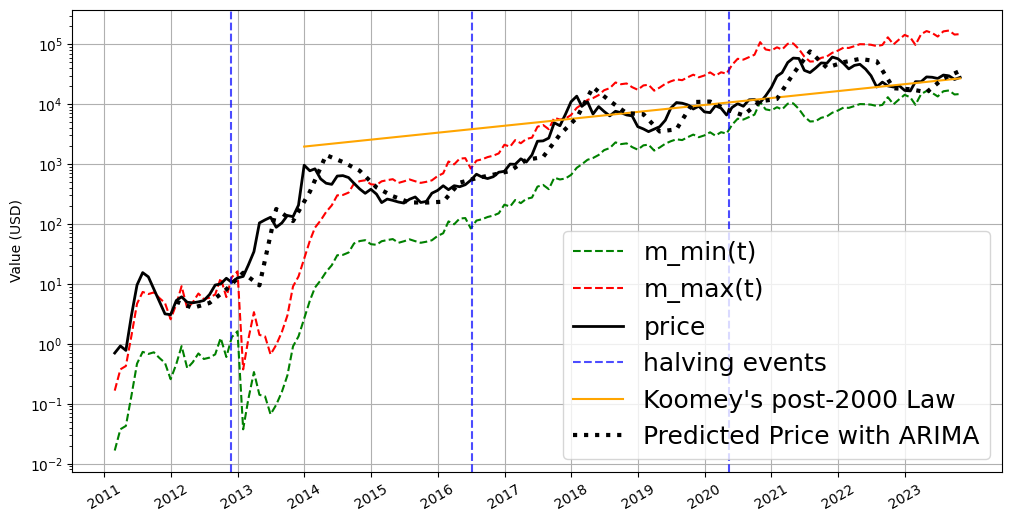

In [13]:
electricity_costs = np.array([0.03, 0.15]) / (1000*3600)
aux_costs = np.array([1, 2.0])
colors = ['green', 'red']
names = ['m_min(t)', 'm_max(t)']

# func = np.log10
func = lambda x: x

# Calculate cost per coin for each combination
cost_per_coin = [func(joules_per_coin * e * a) for (e, a) in zip(electricity_costs, aux_costs)]
cost_per_coin = [x.rename(columns={'joules_per_coin': names[i]}) for i, x in enumerate(cost_per_coin)]
cost_per_coin = pd.concat(cost_per_coin, axis=1)
cost_per_coin = cost_per_coin.iloc[::-1]

fig, ax = plt.subplots(figsize=(12, 6))  # Increase the width of the plot

# Plot each cost per coin with the specified colors and labels using LaTeX for subscript
for i, color in enumerate(colors):
    ax.plot(cost_per_coin.index, cost_per_coin[names[i]], linestyle='--', color=color, label=f'{names[i]}')


# Plot log_price with a thick black line
ax.plot(log_price.index, 10**log_price, alpha=1, color='black', linewidth=2, label='price')

# Add vertical lines for halving events
halving_dates = pd.to_datetime(['2012-11-28', '2016-07-09', '2020-05-11', '2024-04-01'])
for date in halving_dates[:-1]:
    ax.axvline(x=date, color='blue', linestyle='--', alpha=0.7, label='halving events' if date == halving_dates[0] else "")

# Set x-ticks to every year and format them to include "01.01."
years = pd.date_range(start=Timestamp('2010-12-31 00:00:00'), end=cost_per_coin.index.max(), freq='YS')
ax.set_xticks(years)

# ax.set_xticklabels([f"01.01.{year.year}" for year in years], rotation=30)
ax.set_xticklabels([f"{year.year}" for year in years], rotation=30)

# Set y-axis label and format y-ticks to display as 10^x
ax.set_ylabel('Value (USD)', rotation='vertical')
# ax.set_yscale('log')
# ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'$10^{{{int(x)}}}$'))
ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'$10^{{{int(np.log10(x))}}}$'))


# Interpolate the initial price for the start_date
start_date = pd.Timestamp('2013-12-31')
if start_date not in price.index:
    initial_price = price.reindex(price.index.union([start_date])).interpolate(method='time').loc[start_date]
else:
    initial_price = price.loc[start_date]

# Add Koomey's post-2000 law
# end_date = pd.Timestamp('2030-12-31')
end_date = pd.Timestamp('2023-10-31')
koomey_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Koomey's law: Doubling efficiency every 2.6 years
koomey_values = (initial_price + 1000) * (2 ** ((koomey_dates - start_date) / pd.Timedelta(days=2.6 * 365.25)))

# Plot Koomey's law
plt.plot(koomey_dates, koomey_values, label="Koomey's post-2000 Law", color='orange')

# # Plot the predicted price
plt.plot(predicted_price['date'], predicted_price['predicted_price'], label='Predicted Price with ARIMA', linestyle=':', color='black', linewidth=3)

# add a grid
ax.grid(True)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(colors) + 2, fancybox=True, shadow=True, fontsize=20)
ax.legend(fontsize=18)

plt.rcParams.update({'font.size': 18})

plt.savefig('pdfs/pricepredictions.pdf', format='pdf')
plt.show()
plt.rcParams.update({'font.size': fs})

In [14]:
electricity_costs = np.array([0.03, 0.05, 0.07]) / (1000*3600)
aux_costs = np.array([1, 1.1, 1.2])

In [15]:
# Left plot stuff:
colors = ['blue', 'blue', 'blue']
names = ['m_min(t)', 'm_middle(t)', 'm_max(t)']
names2 = ['C = 0.03 USD/kWh; PUE = 1.0', 'C = 0.05 USD/kWh; PUE = 1.1', 'C = 0.07 USD/kWh; PUE = 1.2']

# func = np.log10
func = lambda x: x

# Calculate cost per coin for each combination
cost_per_coin = [func(joules_per_coin * e * a) for (e, a) in zip(electricity_costs, aux_costs)]
cost_per_coin = [x.rename(columns={'joules_per_coin': names[i]}) for i, x in enumerate(cost_per_coin)]
cost_per_coin = pd.concat(cost_per_coin, axis=1)
cost_per_coin = cost_per_coin.iloc[::-1]




# Right plot stuff:
# Convert index to datetime
joules_per_second.index = pd.to_datetime(joules_per_second.index)

# Resample to daily frequency and interpolate
daily_joules_per_second = joules_per_second.resample('D').interpolate(limit_direction='both')

# Convert joules per second to TWH
twh_per_day = daily_joules_per_second * 24 * 1e-12

# Apply PUE = 1.1
twh_per_day = twh_per_day * 1.1

# Calculate cumulative TWH
cumulative_twh = twh_per_day.cumsum()





In [16]:
# create table where for each jan first starting with 2012, we have the cumulative and daily TWH
electricity_table = pd.DataFrame(index=pd.date_range(start='2011-01-01', end='2023-01-01', freq='YS'))
electricity_table['daily_twh'] = twh_per_day.resample('YS').last()
electricity_table['yearly_twh'] = twh_per_day.resample('YS').sum()
electricity_table['cumulative_twh'] = cumulative_twh.resample('YS').last()

electricity_table.index = range(2011, 2024)
electricity_table = electricity_table.T
values = ["Daily", "Yearly", "Cumulative"]
electricity_table["values"] = values
electricity_table = electricity_table[['values'] + [col for col in electricity_table.columns if col != 'values']]
# print(electricity_table.to_latex(float_format="%.4f", index=False))
# use scientific notation with 0.x*10^y format
print(electricity_table.to_latex(float_format="%.1e", index=False))

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
values & 2011 & 2012 & 2013 & 2014 & 2015 & 2016 & 2017 & 2018 & 2019 & 2020 & 2021 & 2022 & 2023 \\
\midrule
Daily & 6.8e-05 & 2.1e-04 & 3.5e-04 & 6.1e-03 & 8.3e-03 & 1.4e-02 & 4.4e-02 & 1.1e-01 & 2.0e-01 & 2.6e-01 & 2.6e-01 & 4.7e-01 & 4.9e-01 \\
Yearly & 3.2e-02 & 3.8e-02 & 2.3e-02 & 1.3e+00 & 2.5e+00 & 4.2e+00 & 9.3e+00 & 3.8e+01 & 5.7e+01 & 8.2e+01 & 9.0e+01 & 1.2e+02 & 1.5e+02 \\
Cumulative & 3.2e-02 & 7.0e-02 & 9.4e-02 & 1.4e+00 & 3.9e+00 & 8.1e+00 & 1.7e+01 & 5.6e+01 & 1.1e+02 & 2.0e+02 & 2.9e+02 & 4.1e+02 & 5.5e+02 \\
\bottomrule
\end{tabular}



<Figure size 960x720 with 0 Axes>

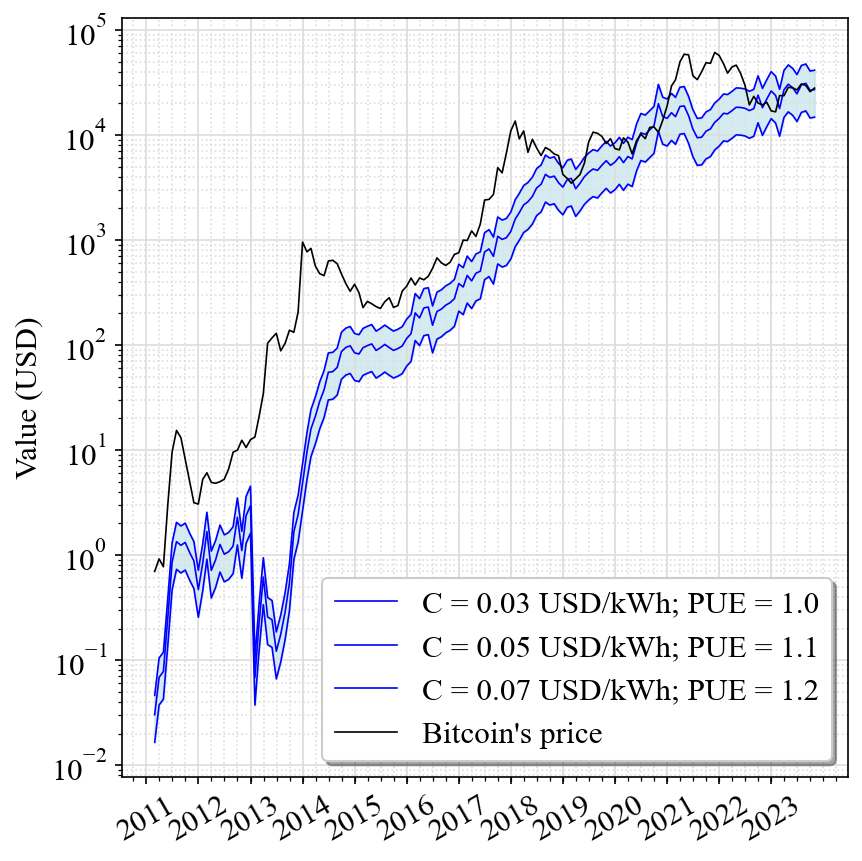

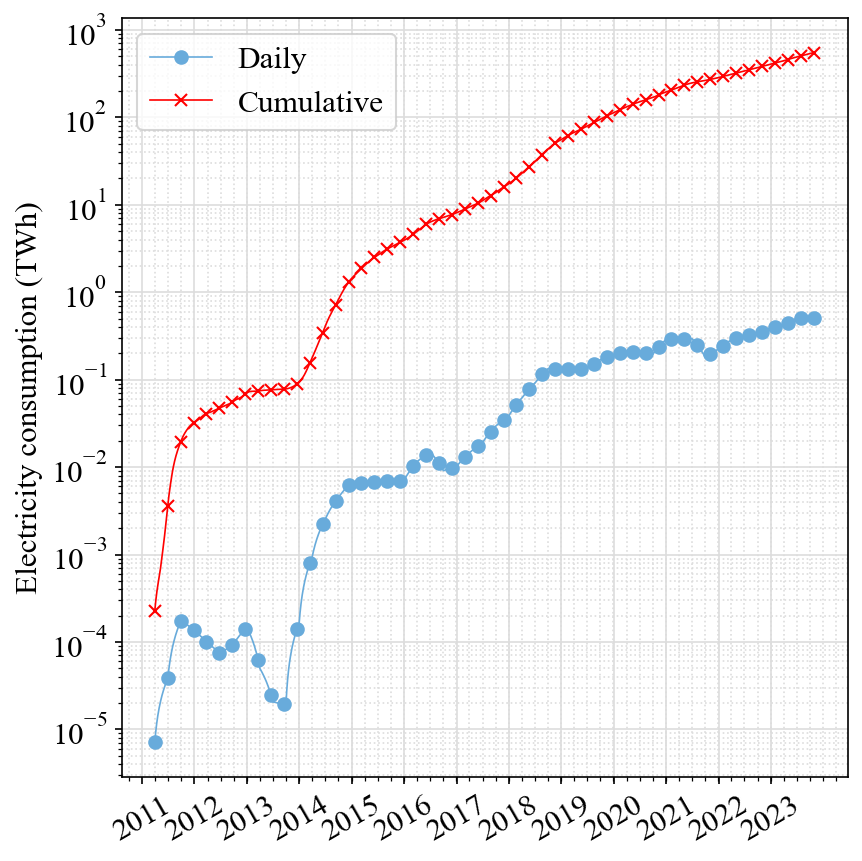

In [17]:

# Define the first plotting function
def plot_cost_per_coin(ax, cost_per_coin, log_price, names, names2, colors):
    # Plot each cost per coin with the specified colors and labels using LaTeX for subscript
    for i, color in enumerate(colors):
        ax.plot(cost_per_coin.index, cost_per_coin[names[i]], linestyle='-', linewidth=0.8, color=color, label=f'{names2[i]}')

    # Plot log_price with a thick black line
    # print(log_price)
    ax.plot(log_price.index, 10**log_price, alpha=1, color='black', linewidth=0.8, label="Bitcoin's price")

    # Fill the area between m_min(t) and m_max(t) with light blue shade
    ax.fill_between(cost_per_coin.index, cost_per_coin['m_min(t)'], cost_per_coin['m_max(t)'], color='lightblue', alpha=0.5)

    # Set x-ticks to every year and format them to include "01.01."
    years = pd.date_range(start=pd.Timestamp('2010-12-31 00:00:00'), end=cost_per_coin.index.max(), freq='YS')
    ax.set_xticks(years)
    ax.set_xticklabels([f"{year.year}" for year in years], rotation=30)

    # Set y-axis label and format y-ticks to display as 10^x
    ax.set_ylabel('Value (USD)', rotation='vertical')

    ax.set_yscale('log')
    # ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'$10^{{{int(np.log10(x))}}}$'))
    ax.set_yscale('log')

    # Add more gridlines
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
    ax.minorticks_on()

    # Add legend with the specified changes
    handles, labels = ax.get_legend_handles_labels()
    labels = labels[:-1] + ["Bitcoin's price"]
    ax.legend(handles, labels, loc='lower right', fancybox=True, shadow=True, fontsize=fs)

# Define the second plotting function
def plot_twh(ax, daily_joules_per_second, twh_per_day, cumulative_twh):
    # Get average twh_per_day on a quarterly basis for smoothing
    quarterly_twh_per_day = twh_per_day.resample('Q').mean()
    # print(twh_per_day)

    # Convert it back to daily
    quarterly_twh_per_day = quarterly_twh_per_day.resample('D').interpolate()
    # Make it end at the same day as the last day of the daily data
    quarterly_twh_per_day = quarterly_twh_per_day[:twh_per_day.index[-1]]
    # Trim cumulative_twh to start at the same day as quarterly_twh_per_day
    start_date = quarterly_twh_per_day.index[0]
    cumulative_twh = cumulative_twh[start_date:]

    # Plot daily TWH (linestyle: dots on solid line, with markers only once per month)
    ax.plot(quarterly_twh_per_day.index, quarterly_twh_per_day, label='Daily', linestyle='-', marker='o', markevery=90, color=(104/255, 171/255, 219/255), linewidth=0.8)

    # Plot cumulative TWH with RGB (104, 171, 219) color
    ax.plot(cumulative_twh.index, cumulative_twh, label='Cumulative', linestyle='-', marker='x', markevery=90, color='red', linewidth=0.8)

    # Set log scale
    ax.set_yscale('log')

    # Set x-axis to show every year but only the year
    years = pd.date_range(start=pd.Timestamp('2010-12-31 00:00:00'), end=daily_joules_per_second.index.max(), freq='YS')
    ax.set_xticks(years)
    ax.set_xticklabels([year.year for year in years], rotation=30)

    # Add more gridlines
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
    ax.minorticks_on()

    # Add labels
    # ax.set_xlabel('Date')
    ax.set_ylabel('Electricity consumption (TWh)')

    # Add legend
    ax.legend(fontsize=fs)



# # Create a figure with two subplots side by side
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# # Plot the first subplot
# plot_cost_per_coin(axs[0], cost_per_coin, log_price, names, names2, colors)

# # Plot the second subplot
# plot_twh(axs[1], daily_joules_per_second, twh_per_day, cumulative_twh)

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Make the font larger
plt.rcParams.update({'font.size': fs})

# Increase DPI
plt.rcParams.update({'figure.dpi': 150})
plt.savefig('pdfs/combined.pdf', format='pdf')
plt.show()

# Plot them individually
fig, ax = plt.subplots(figsize=(6, 6))
plot_cost_per_coin(ax, cost_per_coin, log_price, names, names2, colors)
plt.tight_layout()
plt.savefig('pdfs/enveloppe.pdf', format='pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
plot_twh(ax, daily_joules_per_second, twh_per_day, cumulative_twh)
plt.tight_layout()
plt.savefig('pdfs/climate.pdf', format='pdf', bbox_inches='tight')
plt.show()

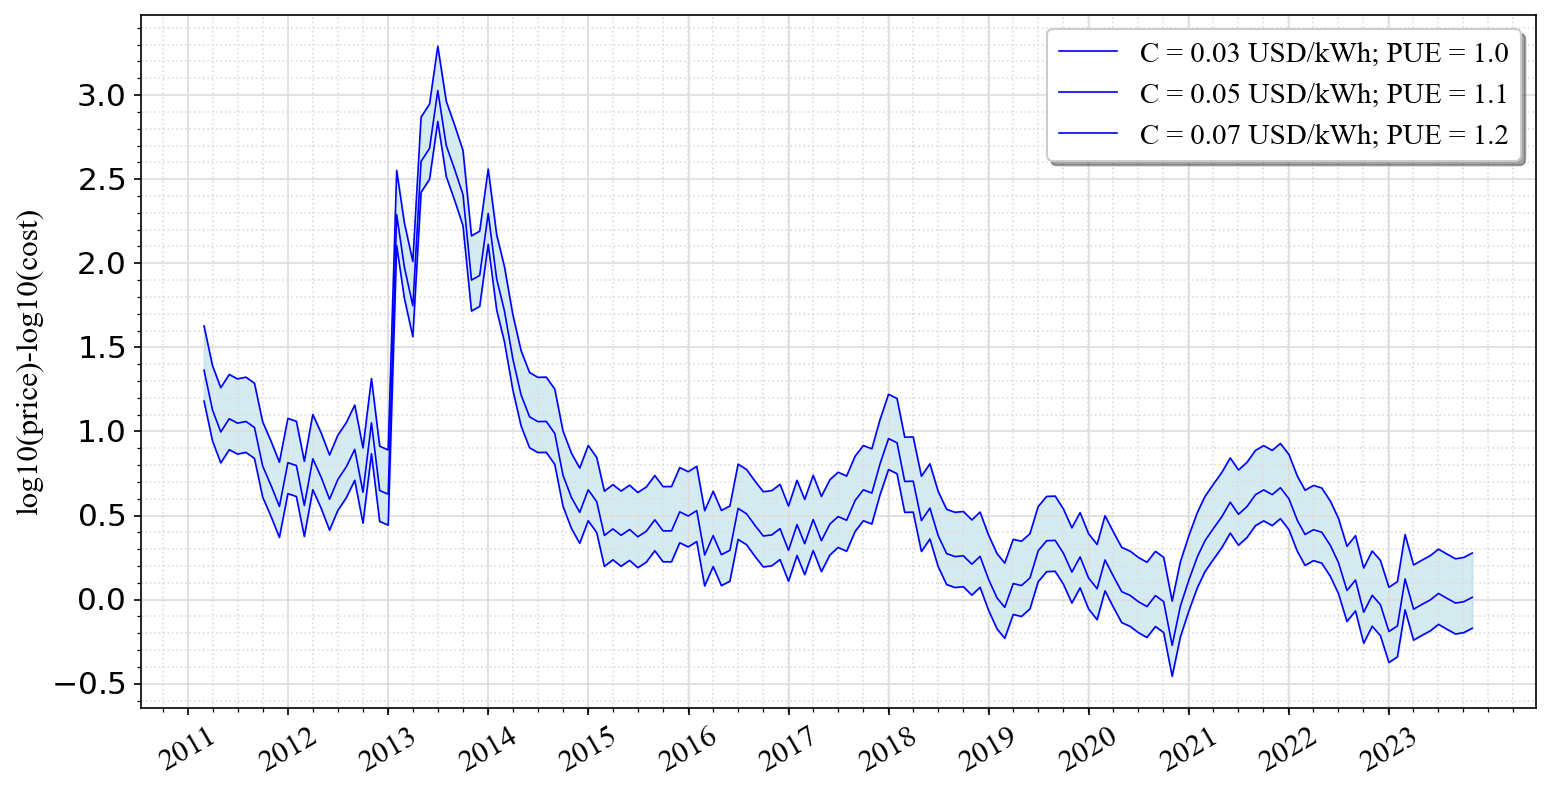

In [18]:
colors = ['blue', 'blue', 'blue']
names = ['m_min(t)', 'm_middle(t)', 'm_max(t)']
# names2 = ['C = 0.03 USD/kWh; PUE = 1.0', 'C = 0.05 USD/kWh; PUE = 1.1', 'C = 0.07 USD/kWh; PUE = 1.2']


# Calculate cost per coin for each combination and log-transform them
cost_per_coin = [np.log10(joules_per_coin * e * a) for (e, a) in zip(electricity_costs, aux_costs)]
cost_per_coin = [x.rename(columns={'joules_per_coin': names[i]}) for i, x in enumerate(cost_per_coin)]
cost_per_coin = pd.concat(cost_per_coin, axis=1)
cost_per_coin = cost_per_coin.iloc[::-1]

# Calculate the price minus each of the cost lines
price_minus_cost = pd.DataFrame(index=cost_per_coin.index)
for name in names:
    price_minus_cost[name] = log_price - cost_per_coin[name]

fig, ax = plt.subplots(figsize=(12, 6))  # Increase the width of the plot

# Plot each price minus cost per coin with the specified colors and labels using LaTeX for subscript
for i, color in enumerate(colors):
    lab = f'log10(price) – log10({names2[i]})'
    lab = names2[i]
    ax.plot(price_minus_cost.index, price_minus_cost[names[i]], linestyle='-', linewidth=0.8, color=color, label=lab)

# Fill the area between price - m_min(t) and price - m_max(t) with light blue shade
ax.fill_between(price_minus_cost.index, price_minus_cost['m_min(t)'], price_minus_cost['m_max(t)'], color='lightblue', alpha=0.5)

# Set x-ticks to every year and format them to include "01.01."
years = pd.date_range(start=pd.Timestamp('2010-12-31 00:00:00'), end=price_minus_cost.index.max(), freq='YS')
ax.set_xticks(years)
ax.set_xticklabels([f"{year.year}" for year in years], rotation=30)

# Set y-axis label and format y-ticks to display as 10^x
ax.set_ylabel('log10(price)-log10(cost)', rotation='vertical')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${{{str(x)}}}$')) #.rstrip(".0")

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Make the font larger
fs = 14
plt.rcParams.update({'font.size': fs})

# Increase DPI
plt.rcParams.update({'figure.dpi': 250})

# Rotate x-ticks
plt.xticks(rotation=30)

# Add a grid
# Add more gridlines
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
ax.minorticks_on()



# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(colors) + 2, fancybox=True, shadow=True)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True)
plt.savefig('pdfs/profit.pdf', format='pdf')
plt.show()

In [19]:
# for each column in cost_per_coin, take 10^x
for col in cost_per_coin.columns:
    cost_per_coin[col] = 10**cost_per_coin[col]

In [20]:
# Calculate daily gains for each mining cost
daily_gains = pd.DataFrame(index=cost_per_coin.index)
# for i in range(5):
#     daily_gains[f'm_{i}(t)'] = (10**log_price - cost_per_coin[f'm_{i}(t)']) / cost_per_coin[f'm_{i}(t)']
for name in names[::-1]:
    daily_gains[f"{name}'s profits"] = (10**log_price - cost_per_coin[name]) / cost_per_coin[name]
# daily_gains["Profit"] = (10**log_price - cost_per_coin[f'm_min(t)']) / cost_per_coin[f'm_min(t)']

# Resample to yearly and calculate the average daily gains
yearly_gains = daily_gains.resample('Y').mean()

# Convert the gains to percentage increase
yearly_gains_percentage = yearly_gains * 100

# Format the gains as strings with percentage increase
yearly_gains_str = yearly_gains_percentage.applymap(lambda x: f'{x:+.0f}%')

# Transpose the DataFrame to have years as columns and mining costs as rows
profits_df = yearly_gains_str.T

# Display the DataFrame
profits_df

C:\Users\Timothe\AppData\Local\Temp\ipykernel_29756\3936055862.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  yearly_gains_str = yearly_gains_percentage.applymap(lambda x: f'{x:+.0f}%')


date,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31,2023-12-31
m_max(t)'s profits,+571%,+280%,+20497%,+1202%,+82%,+66%,+158%,+106%,+2%,-28%,+129%,+10%,-35%
m_middle(t)'s profits,+925%,+480%,+31358%,+1888%,+178%,+153%,+294%,+215%,+56%,+9%,+249%,+68%,-1%
m_min(t)'s profits,+1778%,+963%,+57572%,+3545%,+410%,+364%,+622%,+477%,+185%,+100%,+540%,+209%,+82%


In [21]:
# Calculate the log10 of the absolute values of the profits
log_abs_profits = profits_df.applymap(lambda x: np.log10(abs(float(x.strip('%').strip('+').strip('\\')) / 100)))
sign_profits = profits_df.applymap(lambda x: 1 if '+' in x else -1)

# Normalize the log profits for positive and negative values separately
max_positive = log_abs_profits[sign_profits > 0].max().max()
min_positive = log_abs_profits[sign_profits > 0].min().min()
max_negative = log_abs_profits[sign_profits < 0].max().max()
min_negative = log_abs_profits[sign_profits < 0].min().min()

def get_color(value, sign):
    if sign > 0:
        normalized_value = (value - min_positive) / (max_positive - min_positive)
        red = int((1 - normalized_value) * 255)
        green = 255
    else:
        normalized_value = (value - min_negative) / (max_negative - min_negative)
        red = 255
        green = int((1 - normalized_value) * 255)
    return f'\\cellcolor[RGB]{{{red},{green},0}}'

# Start the LaTeX table
latex_code = "\\documentclass{article}\n\\usepackage{colortbl}\n\\usepackage{booktabs}\n\\usepackage{graphicx}\n\\usepackage{array}\n\\begin{document}\n"
latex_code += "\\newcolumntype{C}[1]{>{\\centering\\arraybackslash}p{#1}}\n"
latex_code += "\\begin{table}[ht]\n\\centering\n\\resizebox{\\textwidth}{!}{%\n\\begin{tabular}{l" + "C{1.5cm}" * len(profits_df.columns) + "}\n"
latex_code += "\\toprule\n"

# Add the header row
header_row = " & " + " & ".join(profits_df.columns.strftime('%Y')) + " \\\\\n"
latex_code += header_row
latex_code += "\\midrule\n"

# Add the data rows with background colors
for index, row in profits_df.iterrows():
    row_data = " & ".join([f"{get_color(log_abs_profits.at[index, col], sign_profits.at[index, col])}" + val.replace('%', '\\%') for col, val in row.items()])
    latex_code += f"{index} & {row_data} \\\\\n"

# End the LaTeX table
latex_code += "\\bottomrule\n"
latex_code += "\\end{tabular}}\n\\caption{Yearly Profits as Percentage Increase}\n\\label{tab:profits}\n\\end{table}\n"
latex_code += "\\end{document}"

# Print the LaTeX code
print(latex_code)

\documentclass{article}
\usepackage{colortbl}
\usepackage{booktabs}
\usepackage{graphicx}
\usepackage{array}
\begin{document}
\newcolumntype{C}[1]{>{\centering\arraybackslash}p{#1}}
\begin{table}[ht]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{lC{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}}
\toprule
 & 2011 & 2012 & 2013 & 2014 & 2015 & 2016 & 2017 & 2018 & 2019 & 2020 & 2021 & 2022 & 2023 \\
\midrule
m_max(t)'s profits & \cellcolor[RGB]{114,255,0}+571\% & \cellcolor[RGB]{132,255,0}+280\% & \cellcolor[RGB]{25,255,0}+20497\% & \cellcolor[RGB]{96,255,0}+1202\% & \cellcolor[RGB]{162,255,0}+82\% & \cellcolor[RGB]{168,255,0}+66\% & \cellcolor[RGB]{146,255,0}+158\% & \cellcolor[RGB]{156,255,0}+106\% & \cellcolor[RGB]{255,255,0}+2\% & \cellcolor[RGB]{255,16,0}-28\% & \cellcolor[RGB]{151,255,0}+129\% & \cellcolor[RGB]{215,255,0}+10\% & \cellcolor[RGB]{255,0,0}-35\% \\
m_middle(t)'s profits & \cellcolor[RGB]{102,255,0}+925\% 

C:\Users\Timothe\AppData\Local\Temp\ipykernel_29756\730861610.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_abs_profits = profits_df.applymap(lambda x: np.log10(abs(float(x.strip('%').strip('+').strip('\\')) / 100)))
C:\Users\Timothe\AppData\Local\Temp\ipykernel_29756\730861610.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sign_profits = profits_df.applymap(lambda x: 1 if '+' in x else -1)


In [22]:
price = 10**log_price

price = pd.DataFrame(price)
price = price.rename(columns={0: 'price'})
# price["c_mining"] = cost_per_coin["m_2(t)"]
price

,price
date,
2011-02-28,0.7000
2011-03-31,0.9202
2011-04-30,0.7741
2011-05-31,3.0331
2011-06-30,9.5700
...,...
2023-06-30,26806.9800
2023-07-31,30589.0500
2023-08-31,29629.2400


In [23]:
cost_per_coin # date m_min(t)	m_max(t)

,m_min(t),m_middle(t),m_max(t)
date,,,
2011-02-28,0.016507,0.030262,0.046219
2011-03-31,0.037427,0.068616,0.104795
2011-04-30,0.042495,0.077908,0.118987
2011-05-31,0.138976,0.254789,0.389133
2011-06-30,0.465775,0.853920,1.304169
...,...,...,...
2023-06-30,13428.347251,24618.636626,37599.372301
2023-07-31,16393.181084,30054.165320,45900.907034
2023-08-31,16929.701012,31037.785189,47403.162835


date
2011-02-28   -1.782337
2011-03-31   -1.426816
2011-04-30   -1.371659
2011-05-31   -0.857060
2011-06-30   -0.331824
                ...   
2023-06-30    4.128023
2023-07-31    4.214663
2023-08-31    4.228649
2023-09-30    4.160938
2023-10-31    4.169560
Name: m_min(t), Length: 153, dtype: float64
Alpha: 1.4845998481021498
Beta: 0.7204375433821413
date
2011-02-28   -1.335179
2011-03-31   -0.979658
2011-04-30   -0.924501
2011-05-31   -0.409902
2011-06-30    0.115334
                ...   
2023-06-30    4.575181
2023-07-31    4.661821
2023-08-31    4.675807
2023-09-30    4.608096
2023-10-31    4.616718
Name: m_max(t), Length: 153, dtype: float64
Alpha: 1.1624504144983656
Beta: 0.7204375433821413


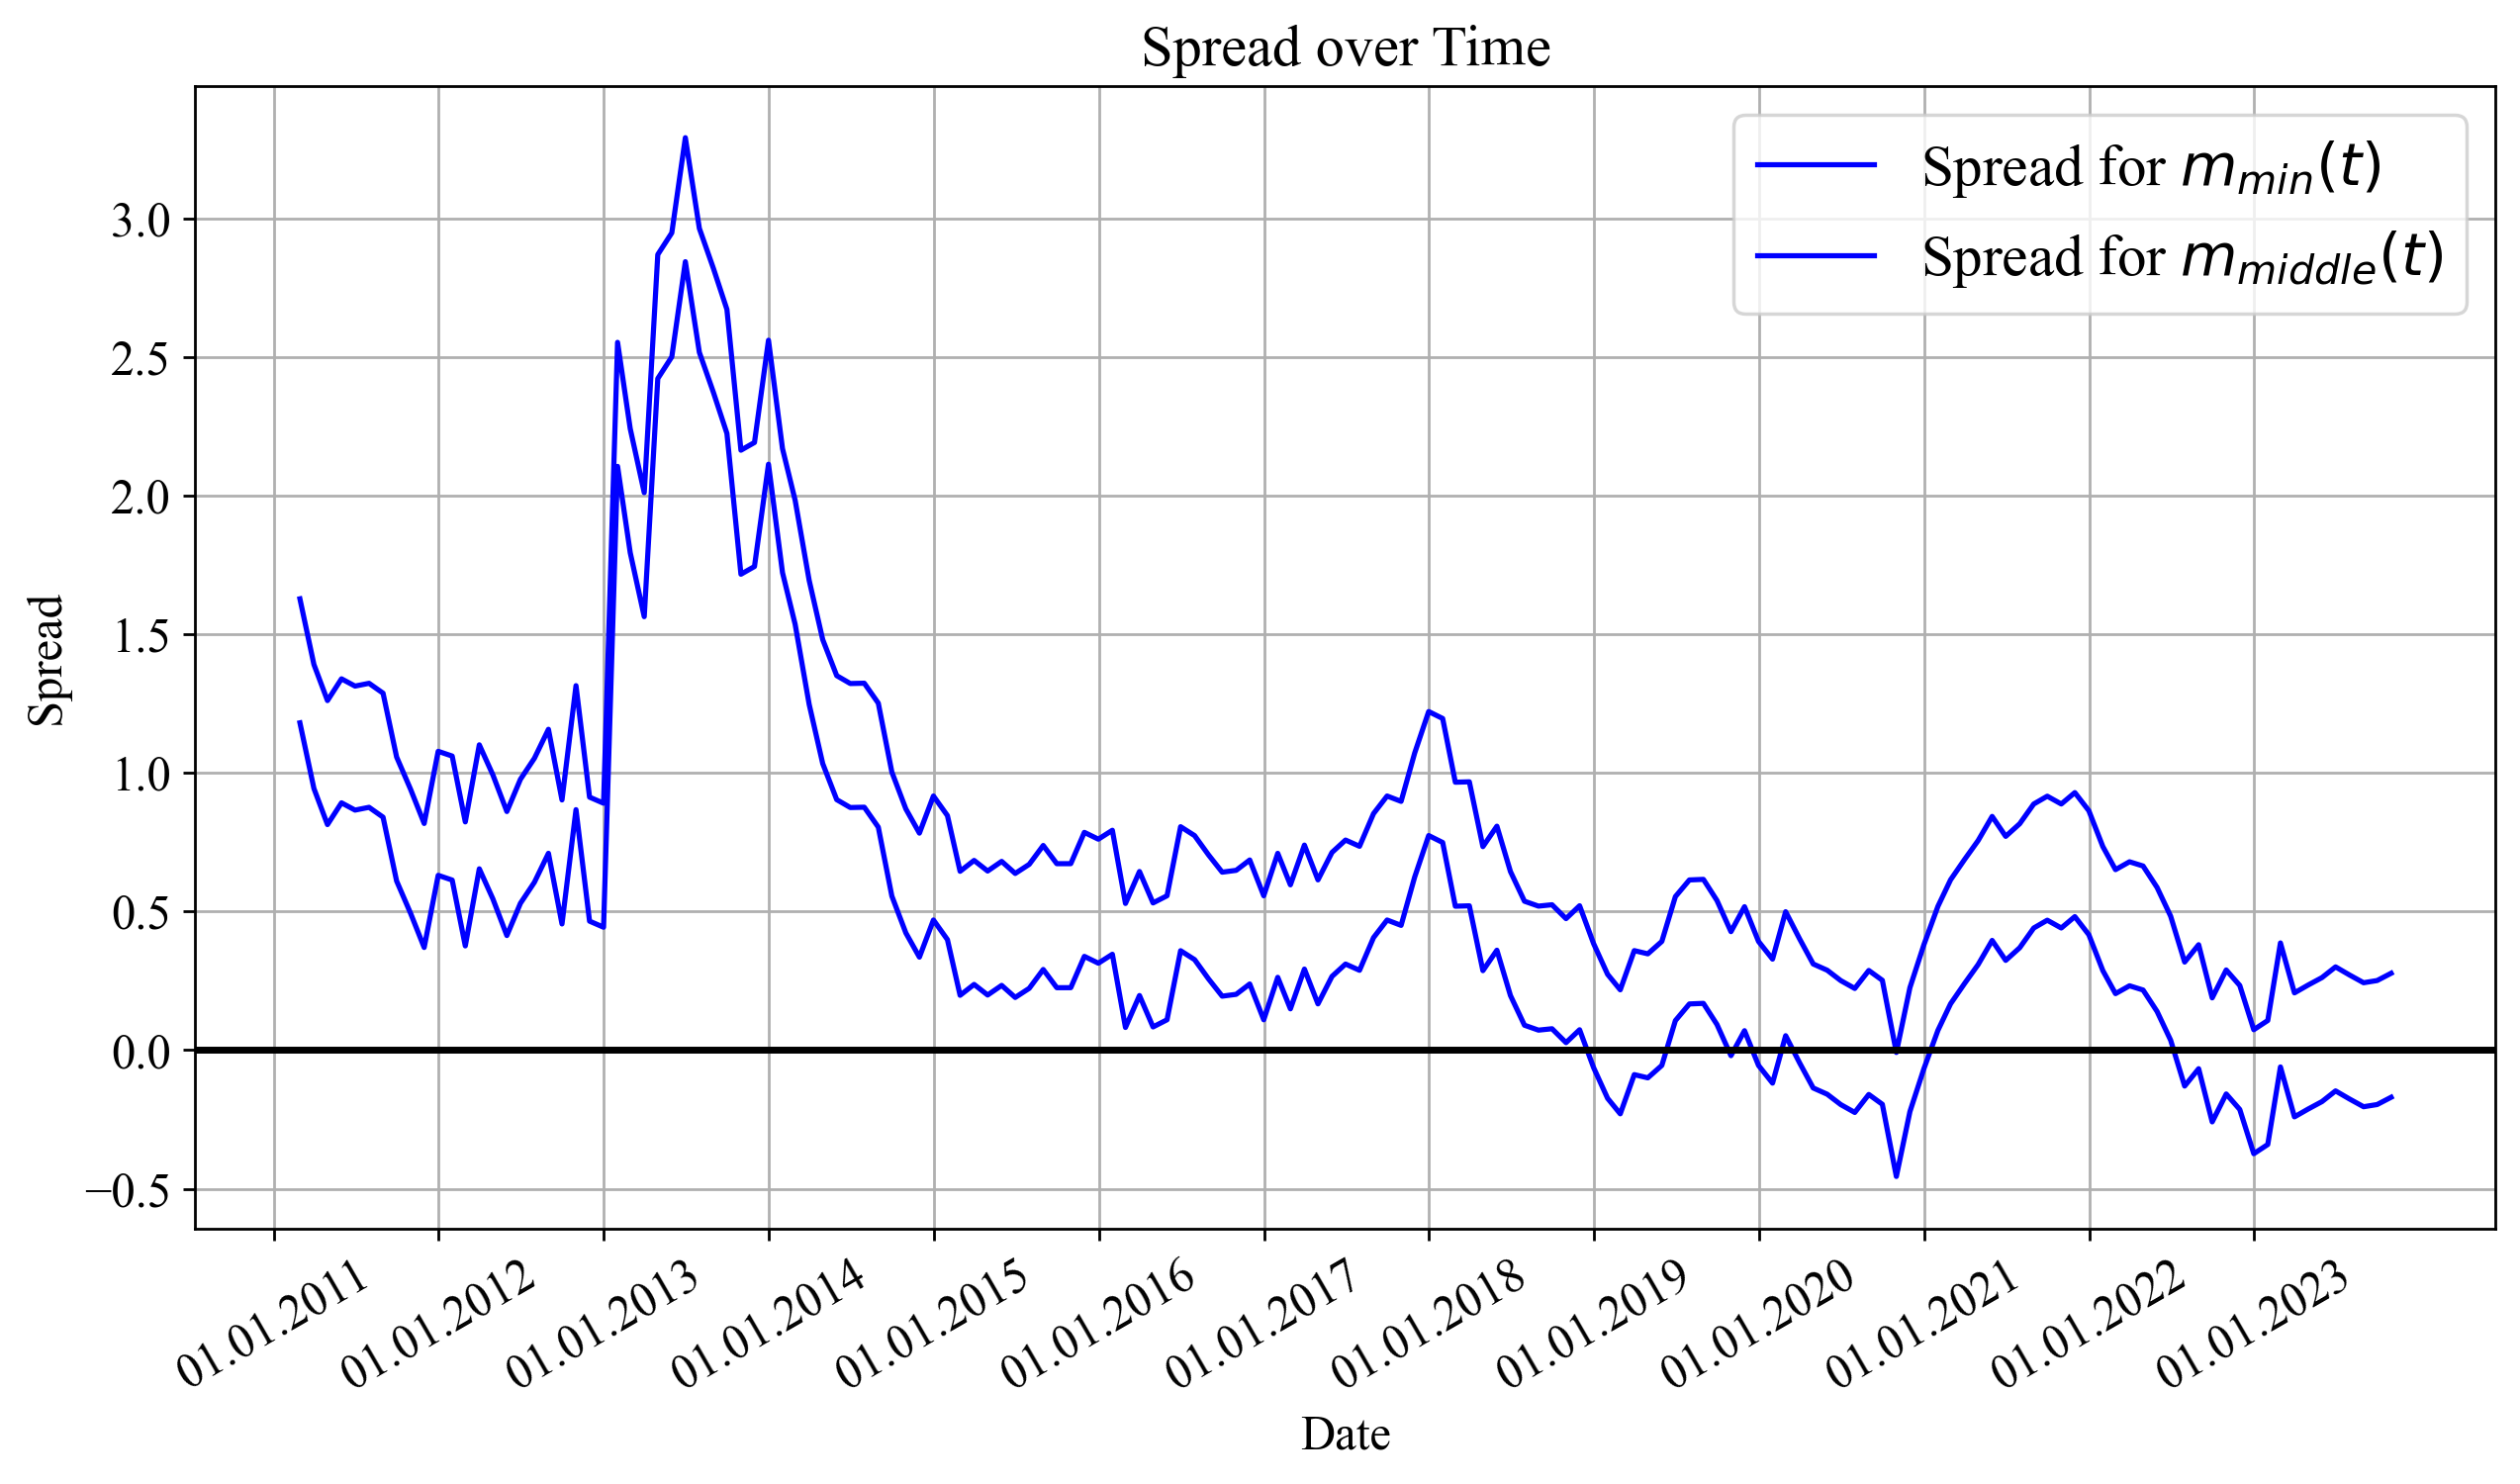

In [24]:

# Calculate log10 of price and c_mining
price['log_price'] = np.log10(price['price'])

# Plot the spread over time
plt.figure(figsize=(12, 6))

i = 0
for thing in [np.log10(cost_per_coin['m_min(t)']), np.log10(cost_per_coin['m_max(t)'])]:
    # Perform linear regression to find alpha and beta
    X = thing
    print(X)
    y = price['log_price']
    X = sm.add_constant(X)  # Adds a constant term to the predictor

    # at some point this broke
    model = sm.OLS(y, X).fit()
    alpha = model.params['const']
    beta = model.params[thing.name]
    print(f"Alpha: {alpha}")
    print(f"Beta: {beta}")
    # beta = 1; alpha = 0



    # Calculate the spread
    # spread = price['log_price'] - beta * thing - alpha
    spread = price['log_price'] - thing
    plt.plot(price.index, spread, label="Spread for $" + names[i].replace("m_","m_{").replace("(","}(") + "$", color=colors[i])
    i += 1

spread = price['log_price'] - beta * thing - alpha
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Spread over Time')
plt.legend(fontsize=17)


# set_xticklabels
years = pd.date_range(start=Timestamp('2010-12-31 00:00:00'), end=price.index.max(), freq='YS')
plt.xticks(years, [f"01.01.{year.year}" for year in years], rotation=30)
plt.xticks(rotation=30)
plt.grid(True)

# Add a thick line at y=0
plt.axhline(y=0, color='black', linewidth=2)
plt.rcParams.update({'font.size': 17})
plt.savefig('pdfs/spread.pdf', format='pdf')
plt.show()
plt.rcParams.update({'font.size': fs})
spread_full = spread
spread_before_turning_point = spread.loc[:'2013-07-01']
spread_after_turning_point = spread.loc['2013-07-01':]


In [25]:
# # Perform Augmented Dickey-Fuller test
# adf_result = adfuller(price['spread'])
# print('ADF Statistic:', adf_result[0])
# print('p-value:', adf_result[1])
# for key, value in adf_result[4].items():
#     print('Critical Values:')
#     print(f'   {key}, {value}')

# # Interpretation of the ADF test
# if adf_result[1] < 0.05:
#     print("The spread is stationary (reject the null hypothesis of a unit root).")
# else:
#     print("The spread is not stationary (fail to reject the null hypothesis of a unit root).")


from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test
ljung_box_result = acorr_ljungbox(spread_full, lags=[10], return_df=True)
print(ljung_box_result)

# Interpretation of the Ljung-Box test
if ljung_box_result['lb_pvalue'].values[0] < 0.05:
    print("The spread is not white noise (reject the null hypothesis of no autocorrelation).")
else:
    print("The spread is white noise (fail to reject the null hypothesis of no autocorrelation).")


# from statsmodels.tsa.stattools import variance_ratio

# # Perform Variance Ratio test
# vr_result = variance_ratio(price['spread'])
# print('Variance Ratio:', vr_result)

# # Interpretation of the Variance Ratio test
# if vr_result < 1:
#     print("The spread is likely to be mean-reverting (not a random walk).")
# else:
#     print("The spread is likely to be a random walk (noise).")


# from scipy.signal import periodogram

# # Perform Spectral Analysis
# frequencies, spectrum = periodogram(price['spread'])

# plt.figure(figsize=(12, 6))
# plt.plot(frequencies, spectrum)
# plt.xlabel('Frequency')
# plt.ylabel('Spectral Density')
# plt.title('Spectral Density of the Spread')
# plt.show()

# Interpretation: A flat spectral density indicates white noise.

       lb_stat      lb_pvalue
10  561.552719  3.018675e-114
The spread is not white noise (reject the null hypothesis of no autocorrelation).


In [26]:
predicted_d_ln_price_df = pd.read_csv('predictions_Quarterly Data_1_1.csv') # date	predicted_d_ln_price
predicted_d_ln_price_df['date'] = pd.to_datetime(predicted_d_ln_price_df['date'])
ln_price = np.log(price['price'])
predicted_price = predicted_d_ln_price_df.copy()

In [27]:
# ln_price.loc["2023-06-30"]

In [28]:
predicted_price

,date,predicted_d_ln_price
0,2020-10-31,0.137904
1,2021-01-31,0.087864
2,2021-04-30,0.257581
3,2021-07-31,0.234906
4,2021-10-31,0.068401
5,2022-01-31,0.201714
6,2022-04-30,0.139961
7,2022-07-31,-0.029190
8,2022-10-31,-0.081949
9,2023-01-31,-0.061788


In [29]:


# go through each (date, predicted_d_ln_price) pair and obtain the predicted price of the next quarter
for i, row in predicted_price.iterrows():
    date = row['date']
    predicted_d_ln_price = row['predicted_d_ln_price']
    # calculate the predicted price of the next quarter
    predicted_price.at[i, 'predicted_ln_price'] = ln_price.loc[date] + predicted_d_ln_price
    predicted_price.at[i, 'ln_price'] = ln_price.loc[date]

# shift the predicted price by one index
predicted_price['predicted_ln_price'] = predicted_price['predicted_ln_price'].shift(1)
predicted_price = predicted_price.dropna()
predicted_price['predicted_price'] = np.exp(predicted_price['predicted_ln_price'])
predicted_price['price'] = np.exp(predicted_price['ln_price'])
predicted_price

C:\Users\Timothe\AppData\Local\Temp\ipykernel_29756\3330187954.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_price['predicted_price'] = np.exp(predicted_price['predicted_ln_price'])
C:\Users\Timothe\AppData\Local\Temp\ipykernel_29756\3330187954.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_price['price'] = np.exp(predicted_price['ln_price'])


,date,predicted_d_ln_price,predicted_ln_price,ln_price,predicted_price,price
1,2021-01-31,0.087864,9.407861,10.285349,12183.784977,29300.190936
2,2021-04-30,0.257581,10.373213,10.981142,31991.103654,58755.615178
3,2021-07-31,0.234906,11.238723,10.423134,76017.786465,33628.670000
4,2021-10-31,0.068401,10.658040,10.780629,42533.204856,48080.372838
5,2022-01-31,0.201714,10.849030,10.769421,51484.199852,47544.499400
6,2022-04-30,0.139961,10.971135,10.741406,58170.593391,46231.004759
7,2022-07-31,-0.029190,10.881367,9.869729,53176.261690,19336.104441
8,2022-10-31,-0.081949,9.840539,9.868128,18779.832376,19305.171900
9,2023-01-31,-0.061788,9.786179,9.717584,17786.214948,16607.069459
10,2023-04-30,-0.078342,9.655796,10.256424,15612.005938,28464.814018


In [30]:
# # Interpolate the initial price for the start_date
# start_date = pd.Timestamp('2013-12-31')
# if start_date not in price.index:
#     initial_price = price['price'].reindex(price.index.union([start_date])).interpolate(method='time').loc[start_date]
# else:
#     initial_price = price.loc[start_date, 'price']

# # Plot the original price and c_mining on a log scale
# plt.figure(figsize=(12, 6))
# plt.plot(price.index, price['price'], label='Price')
# plt.plot(price.index, price['c_mining'], label='Modelled mining costs')
# plt.yscale('log')
# plt.xlabel('Date')
# plt.ylabel('Value (USD)')
# plt.title('Price and Cost of Mining over Time (Log Scale)')


# # Add Koomey's post-2000 law
# end_date = pd.Timestamp('2030-12-31')
# koomey_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# # Koomey's law: Doubling efficiency every 2.6 years
# koomey_values = (initial_price + 1000) * (2 ** ((koomey_dates - start_date) / pd.Timedelta(days=2.6 * 365.25)))

# # Plot Koomey's law
# plt.plot(koomey_dates, koomey_values, label="Koomey's post-2000 Law", linestyle='--', color='red')

# # # Plot the predicted price
# # plt.plot(predicted_price['date'], predicted_price['predicted_price'], label='Predicted Price', linestyle='--', color='green')

# # Plot the halvings
# halving_dates = pd.to_datetime(['2012-11-28', '2016-07-09', '2020-05-11', '2024-04-01'])
# for date in halving_dates[:-1]:
#     plt.axvline(x=date, color='green', linestyle='--', alpha=0.7, label='Halving Events' if date == halving_dates[0] else "")


# # Set x-ticks to show years
# years = pd.date_range(start=Timestamp('2010-12-31 00:00:00'), end=end_date, freq='YS')
# plt.xticks(years, [f"01.01.{year.year}" for year in years], rotation=30)
# plt.grid(True)
# plt.legend()
# plt.show()

In [31]:
# c_mining = pd.DataFrame(price['c_mining'])
# c_mining = c_mining.rename(columns={'c_mining': 'cost_per_coin'})
# c_mining

In [32]:
# c_mining.to_csv('cost_per_coin.csv', index=True)

In [33]:
# from sklearn.metrics import r2_score
# # Interpolate the costs and price to match the dates of Koomey's law
# price_interpolated = price['price'].reindex(koomey_dates).interpolate(method='time')
# c_mining_interpolated = price['c_mining'].reindex(koomey_dates).interpolate(method='time')

# # Transform to log10 scale
# log_koomey_values = np.log10(koomey_values)
# log_price_interpolated = np.log10(price_interpolated)
# log_c_mining_interpolated = np.log10(c_mining_interpolated)

# # Calculate R^2 between Koomey's law and costs in log10 scale
# r2_costs_log = r2_score(log_c_mining_interpolated, log_koomey_values)
# print(f"R^2 between Koomey's law and costs (log10 scale): {r2_costs_log}")

# # Calculate R^2 between Koomey's law and price in log10 scale
# r2_price_log = r2_score(log_price_interpolated, log_koomey_values)
# print(f"R^2 between Koomey's law and price (log10 scale): {r2_price_log}")



In [34]:
# Calculate archaicity profits
df = pd.read_csv('../bitcoinforum/6_calculating_costs/monthly_stuff.csv')
df['date'] = pd.to_datetime(df['date'])
seconds_in_block = 600
df = df[['date', 'hashrate', 'price', 'max_efficiency', 'coins_per_block']]
df = df.iloc[::-1]
df['max_efficiency'] = df['max_efficiency'].ffill()
df['max_efficiency'] = df['max_efficiency'] * 1e12
df.index = df['date']
df = df.drop(columns=['date'])
df

,hashrate,price,max_efficiency,coins_per_block
date,,,,
2011-02-28,3.117778e+11,0.7000,3.780000e+06,50.00
2011-03-31,5.482000e+11,0.9202,3.780000e+06,50.00
2011-04-30,7.260000e+11,0.7741,3.780000e+06,50.00
2011-05-31,2.244000e+12,3.0331,3.780000e+06,50.00
2011-06-30,7.758000e+12,9.5700,3.780000e+06,50.00
...,...,...,...,...
2023-06-30,3.699255e+20,26806.9800,4.650000e+10,6.25
2023-07-31,3.750404e+20,30589.0500,4.650000e+10,6.25
2023-08-31,3.853479e+20,29629.2400,4.650000e+10,6.25


In [35]:
# Constants
electricity_cost_per_joule = 0.10 / (1000 * 3600)  # USD per joule
seconds_in_block = 600

# Function to calculate mining cost
def calculate_mining_cost(hashrate, max_efficiency, coins_per_block):
    joules_per_hash = 1 / max_efficiency
    joules_per_block = hashrate * seconds_in_block * joules_per_hash
    cost_per_block = joules_per_block * electricity_cost_per_joule
    return cost_per_block / coins_per_block

# Initialize a DataFrame to store the results
archaicity_df = pd.DataFrame(index=df.index, columns=['archaicity_months'])

# Iterate through each month
for current_month in df.index:
    max_efficiency = df.loc[current_month, 'max_efficiency']
    archaicity_months = 0
    
    # Iterate through the next months
    for future_month in df.loc[current_month:].index:
        future_hashrate = df.loc[future_month, 'hashrate']
        future_price = df.loc[future_month, 'price']
        future_coins_per_block = df.loc[future_month, 'coins_per_block']
        
        # Calculate mining cost
        mining_cost = calculate_mining_cost(future_hashrate, max_efficiency, future_coins_per_block)
        
        # Check if mining is still profitable
        if mining_cost < future_price:
            archaicity_months += 1
        else:
            break
    
    # Store the result
    archaicity_df.loc[current_month, 'archaicity_months'] = archaicity_months

# Resample to yearly and take the mean
yearly_archaicity = archaicity_df.resample('Y').mean()

print(yearly_archaicity)

           archaicity_months
date                        
2011-12-31         28.272727
2012-12-31         21.166667
2013-12-31         26.666667
2014-12-31              28.0
2015-12-31         34.416667
2016-12-31             26.25
2017-12-31              15.5
2018-12-31          6.083333
2019-12-31              11.0
2020-12-31              11.5
2021-12-31              15.5
2022-12-31              10.0
2023-12-31               5.5


<Axes: xlabel='date'>

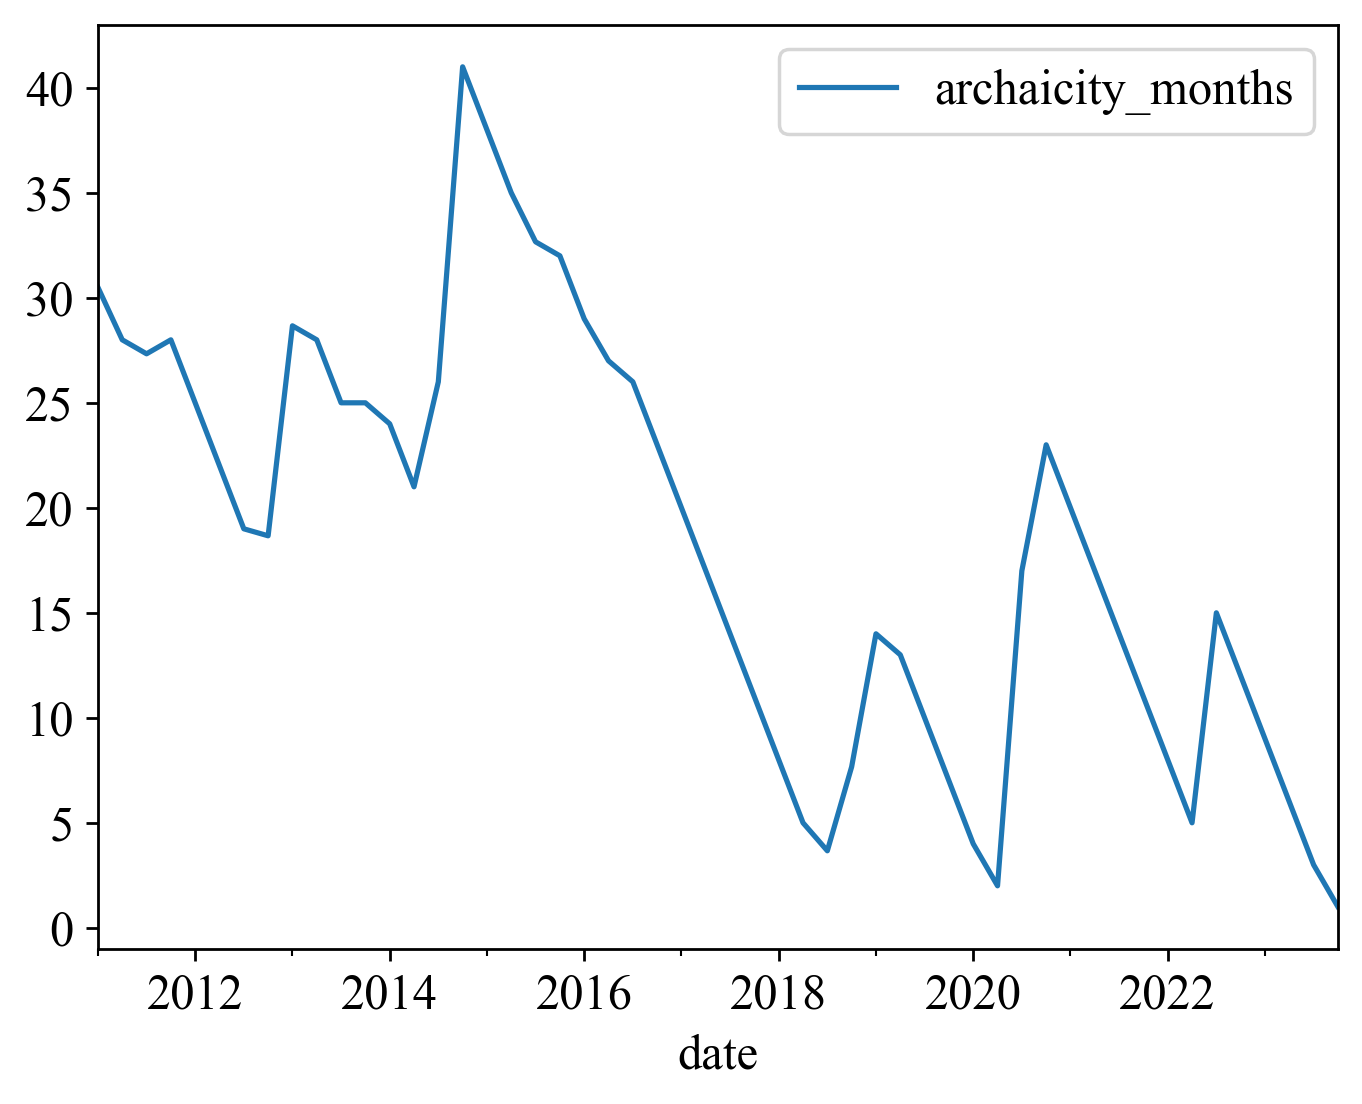

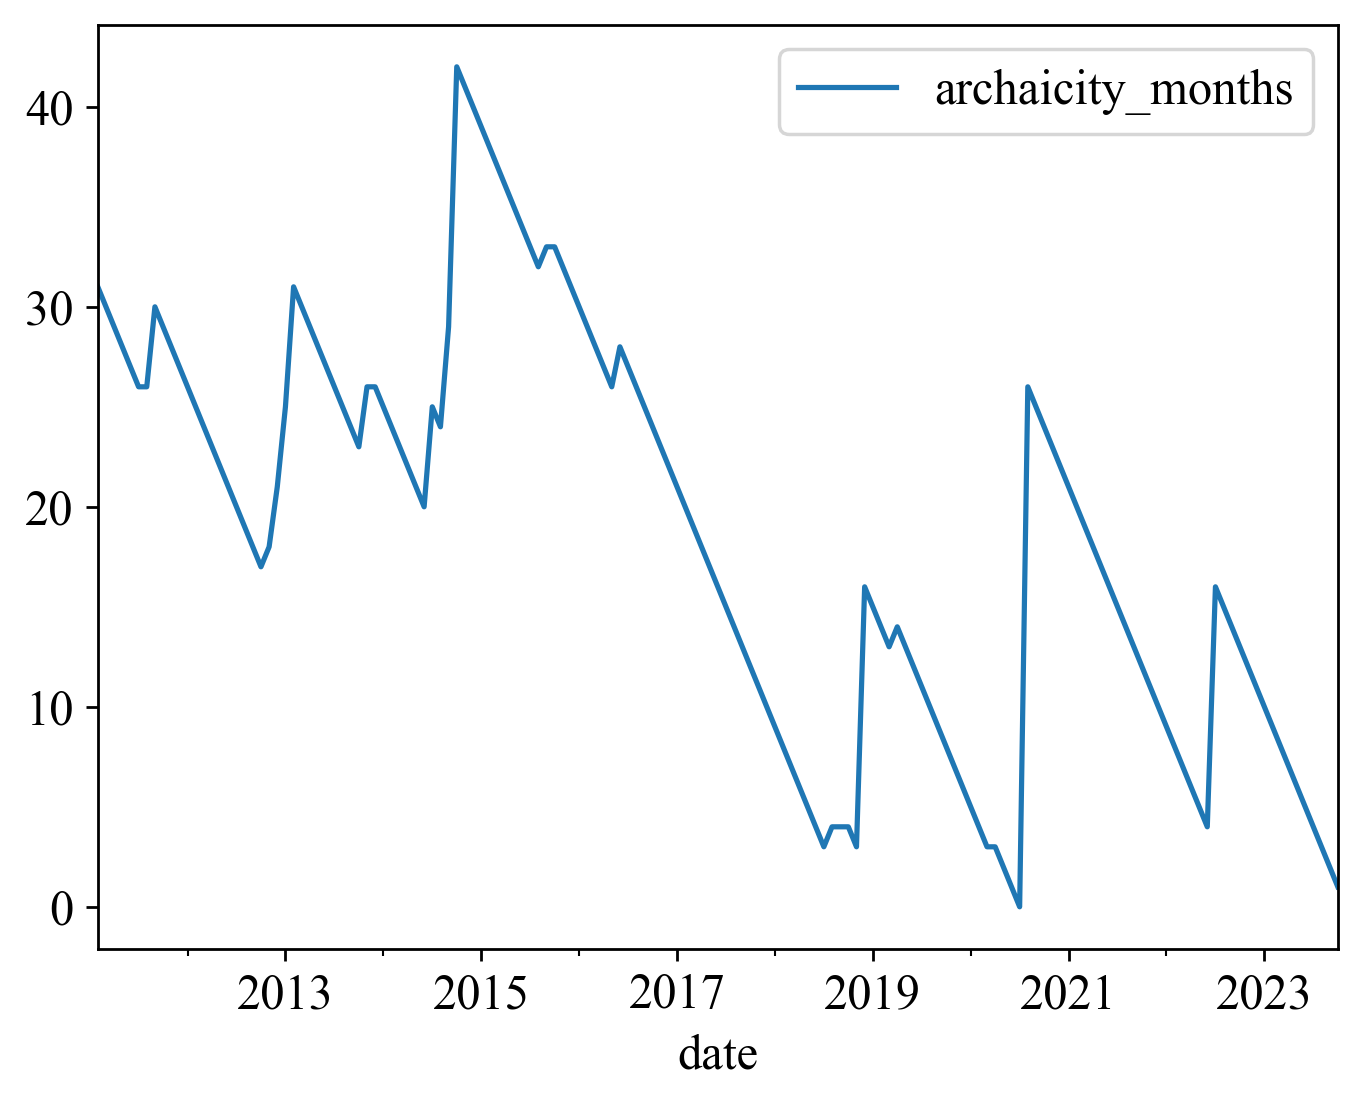

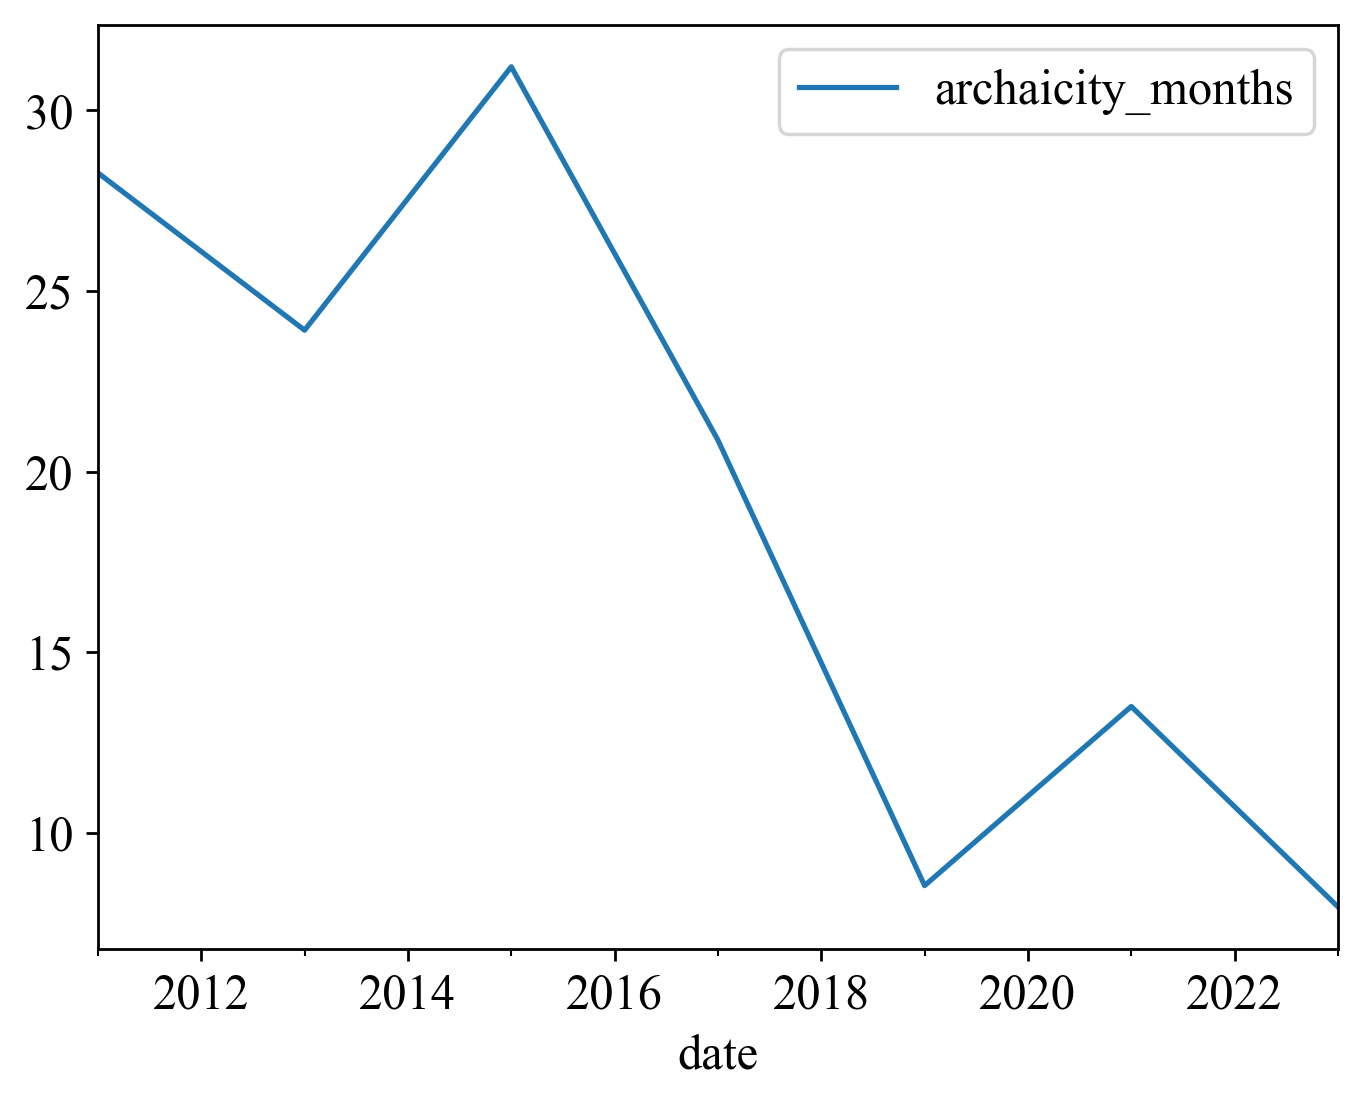

In [36]:
quarterly_archaicity = archaicity_df.resample('Q').mean()
quarterly_archaicity.plot()

monthly_archaicity = archaicity_df.resample('M').mean()
monthly_archaicity.plot()

year2_archaicity = archaicity_df.resample('2Y').mean()
year2_archaicity.plot()

In [37]:
# latex_table = yearly_archaicity.to_latex(index=True, header=True, caption="Yearly Archaicity of Bitcoin Mining Hardware", label="tab:yearly_archaicity", float_format="%.2f")
# print(latex_table)

In [38]:
transposed_yearly_archaicity = yearly_archaicity.T
transposed_yearly_archaicity = transposed_yearly_archaicity*30.44
# Export to LaTeX
latex_table = transposed_yearly_archaicity.to_latex(index=False,float_format="%.2f")
print(latex_table)

\begin{tabular}{lllllllllllll}
\toprule
2011-12-31 00:00:00 & 2012-12-31 00:00:00 & 2013-12-31 00:00:00 & 2014-12-31 00:00:00 & 2015-12-31 00:00:00 & 2016-12-31 00:00:00 & 2017-12-31 00:00:00 & 2018-12-31 00:00:00 & 2019-12-31 00:00:00 & 2020-12-31 00:00:00 & 2021-12-31 00:00:00 & 2022-12-31 00:00:00 & 2023-12-31 00:00:00 \\
\midrule
860.62 & 644.31 & 811.73 & 852.32 & 1047.64 & 799.05 & 471.82 & 185.18 & 334.84 & 350.06 & 471.82 & 304.40 & 167.42 \\
\bottomrule
\end{tabular}



In [39]:
# Calculate archaicity
df = pd.read_csv('../bitcoinforum/6_calculating_costs/monthly_stuff.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'efficiency', 'max_efficiency']]
df = df.iloc[::-1]
df['max_efficiency'] = df['max_efficiency'].ffill()
df['max_efficiency'] = df['max_efficiency'] * 1e12
df.index = df['date']
df = df.drop(columns=['date'])
df

,efficiency,max_efficiency
date,,
2011-02-28,1.888783e+06,3.780000e+06
2011-03-31,1.464722e+06,3.780000e+06
2011-04-30,1.708422e+06,3.780000e+06
2011-05-31,1.614668e+06,3.780000e+06
2011-06-30,1.665613e+06,3.780000e+06
...,...,...
2023-06-30,2.203848e+10,4.650000e+10
2023-07-31,1.830227e+10,4.650000e+10
2023-08-31,1.820932e+10,4.650000e+10


In [40]:
# Initialize a DataFrame to store the results
efficiency_df = pd.DataFrame(index=df.index, columns=['months_until_surpassed'])

# Iterate through each month
for current_month in df.index:
    max_efficiency = df.loc[current_month, 'max_efficiency']
    months_until_surpassed = 0
    
    # Iterate through the next months
    for future_month in df.loc[current_month:].index:
        future_efficiency = df.loc[future_month, 'efficiency']
        
        # Check if future efficiency surpasses current month's max efficiency
        if future_efficiency > max_efficiency:
            break
        else:
            months_until_surpassed += 1
    
    # Store the result
    efficiency_df.loc[current_month, 'months_until_surpassed'] = months_until_surpassed

# Resample to yearly and take the mean
yearly_archaicity = efficiency_df.resample('Y').mean()

print(yearly_archaicity)

           months_until_surpassed
date                             
2011-12-31              12.272727
2012-12-31               6.916667
2013-12-31              18.333333
2014-12-31                  19.25
2015-12-31              18.083333
2016-12-31                  26.25
2017-12-31                   20.5
2018-12-31              16.083333
2019-12-31                   48.5
2020-12-31                   40.5
2021-12-31                   28.5
2022-12-31                   16.5
2023-12-31                    5.5


In [41]:
# archaicity_df = efficiency_df
# quarterly_archaicity = archaicity_df.resample('Q').mean()
# quarterly_archaicity.plot()

# monthly_archaicity = archaicity_df.resample('M').mean()
# monthly_archaicity.plot()

# year2_archaicity = archaicity_df.resample('2Y').mean()
# year2_archaicity.plot()

In [42]:
transposed_yearly_archaicity = yearly_archaicity.T
transposed_yearly_archaicity = transposed_yearly_archaicity*30.44
transposed_yearly_archaicity

date,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31,2023-12-31
months_until_surpassed,373.581818,210.543333,558.066667,585.97,550.456667,799.05,624.02,489.576667,1476.34,1232.82,867.54,502.26,167.42


In [43]:
# Export to LaTeX
latex_table = transposed_yearly_archaicity.to_latex(index=False,float_format="%.2f")
print(latex_table)

\begin{tabular}{lllllllllllll}
\toprule
2011-12-31 00:00:00 & 2012-12-31 00:00:00 & 2013-12-31 00:00:00 & 2014-12-31 00:00:00 & 2015-12-31 00:00:00 & 2016-12-31 00:00:00 & 2017-12-31 00:00:00 & 2018-12-31 00:00:00 & 2019-12-31 00:00:00 & 2020-12-31 00:00:00 & 2021-12-31 00:00:00 & 2022-12-31 00:00:00 & 2023-12-31 00:00:00 \\
\midrule
373.58 & 210.54 & 558.07 & 585.97 & 550.46 & 799.05 & 624.02 & 489.58 & 1476.34 & 1232.82 & 867.54 & 502.26 & 167.42 \\
\bottomrule
\end{tabular}



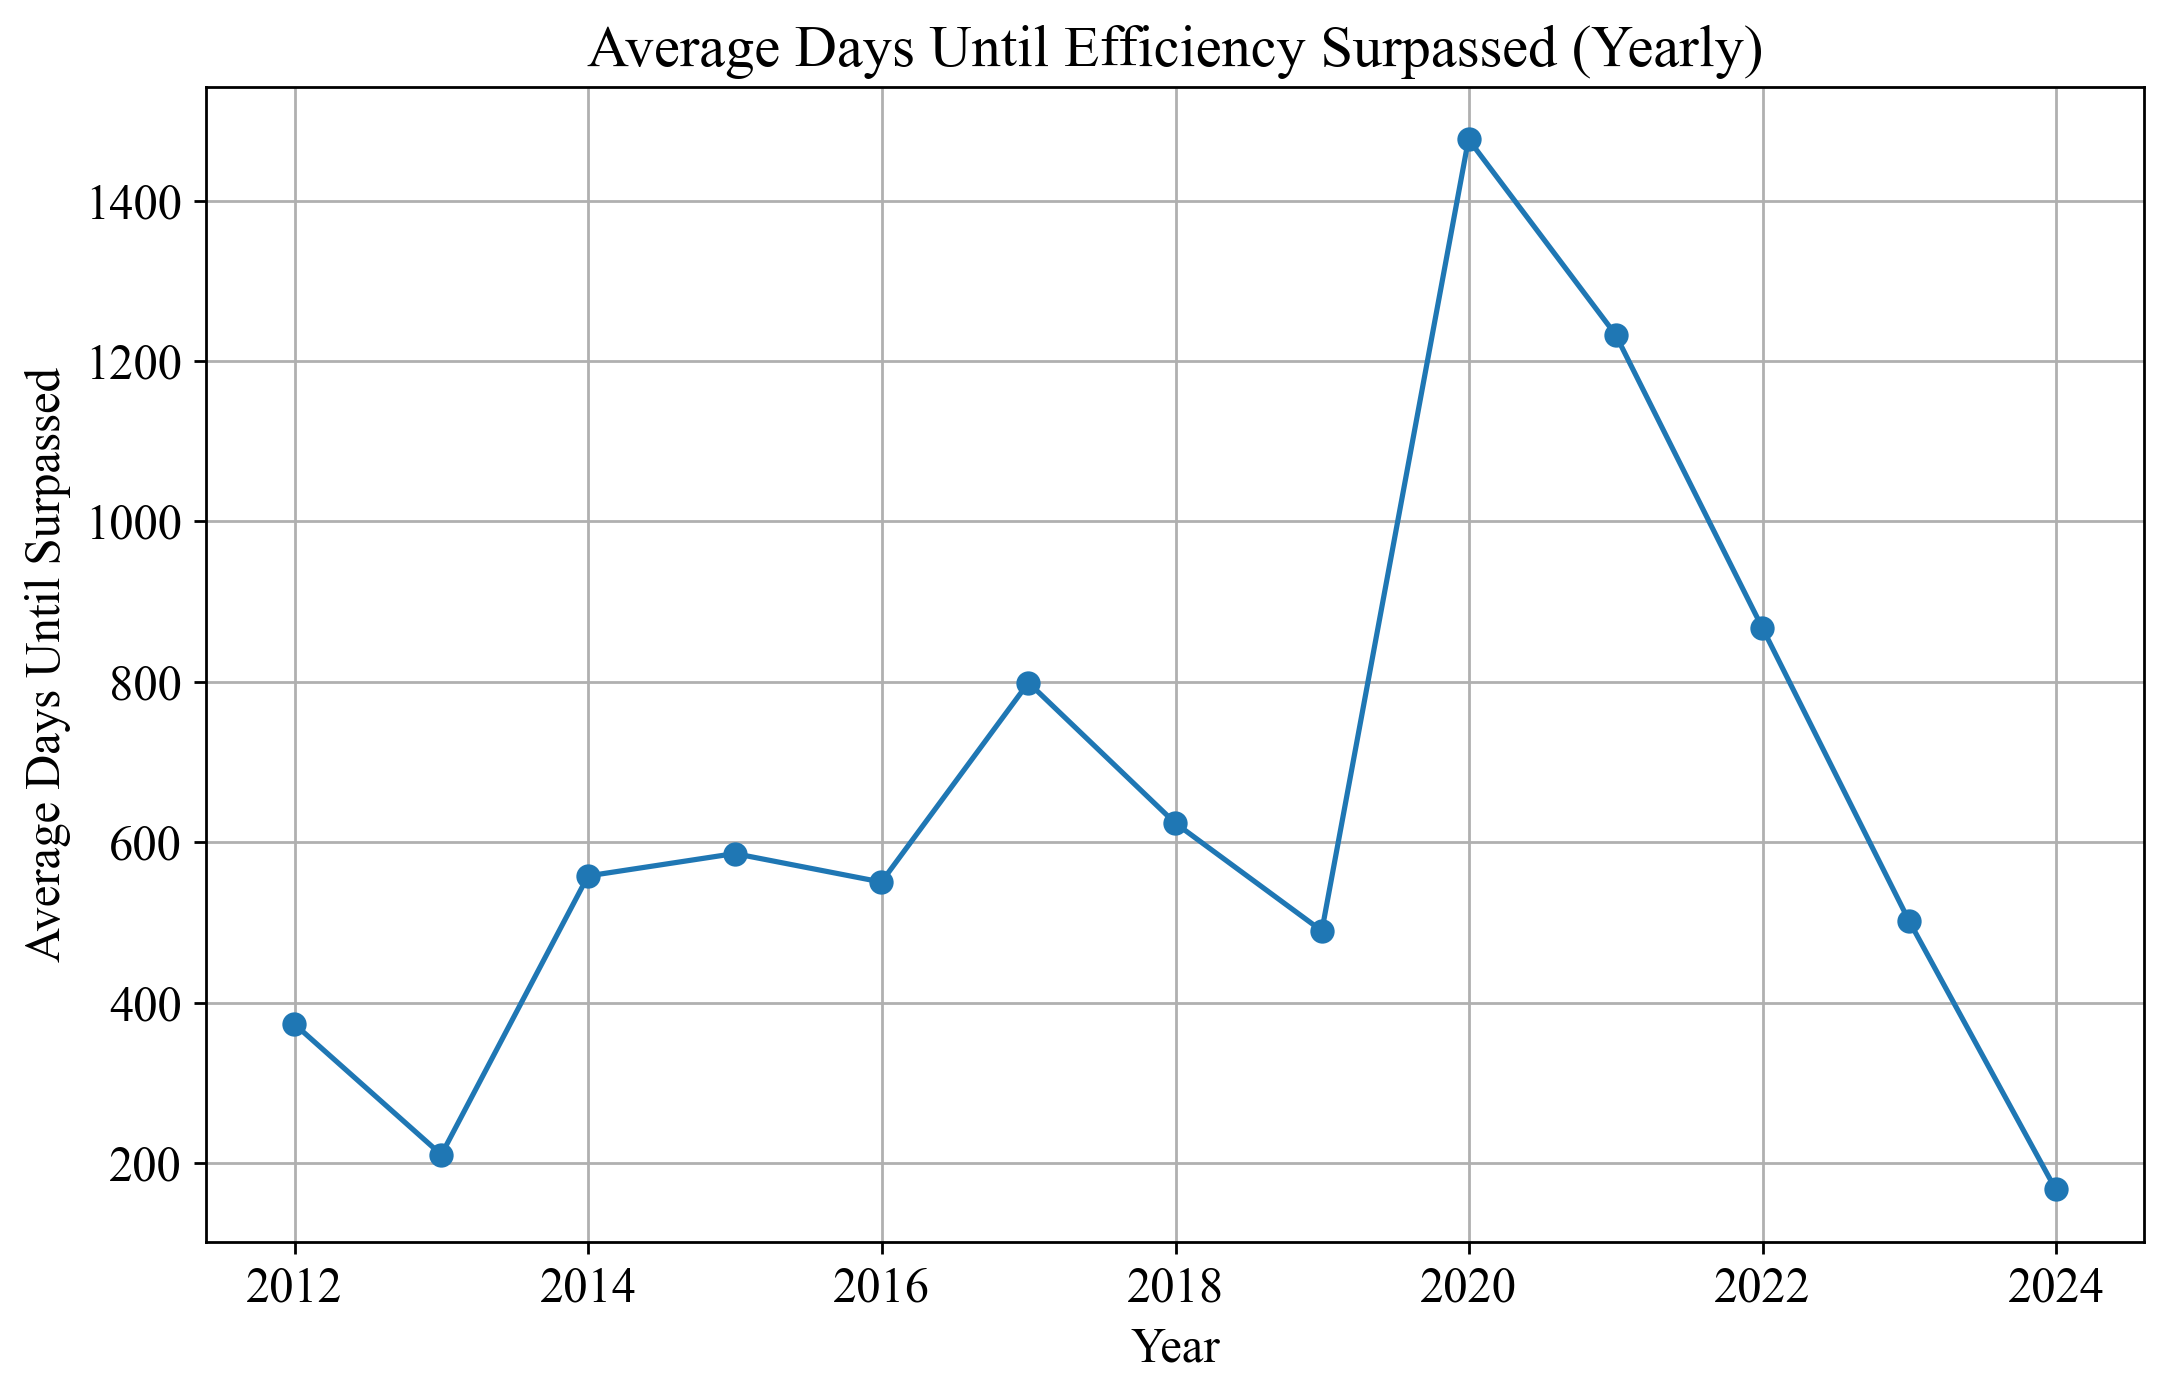

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(yearly_archaicity.index, yearly_archaicity*30.44, marker='o', linestyle='-')
plt.title('Average Days Until Efficiency Surpassed (Yearly)')
plt.xlabel('Year')
plt.ylabel('Average Days Until Surpassed')
plt.grid(True)
plt.show()

In [45]:
df = pd.read_csv('../bitcoinforum/6_calculating_costs/monthly_stuff.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'efficiency', 'max_efficiency']]
df = df.iloc[::-1]
df['max_efficiency'] = df['max_efficiency'].ffill()
df['max_efficiency'] = df['max_efficiency'] * 1e12
df.index = df['date']
df = df.drop(columns=['date'])
df

,efficiency,max_efficiency
date,,
2011-02-28,1.888783e+06,3.780000e+06
2011-03-31,1.464722e+06,3.780000e+06
2011-04-30,1.708422e+06,3.780000e+06
2011-05-31,1.614668e+06,3.780000e+06
2011-06-30,1.665613e+06,3.780000e+06
...,...,...
2023-06-30,2.203848e+10,4.650000e+10
2023-07-31,1.830227e+10,4.650000e+10
2023-08-31,1.820932e+10,4.650000e+10


In [46]:
pmaxv2 = pd.read_csv('../hardwarelist/pmaxv2.csv') # date	max_efficiency
pmaxv2['date'] = pd.to_datetime(pmaxv2['date'])
pmaxv2 = pmaxv2.set_index('date')
pmaxv2

,max_efficiency
date,
2011-01-01,2.010000e+06
2011-01-02,2.010000e+06
2011-01-03,2.010000e+06
2011-01-04,2.010000e+06
2011-01-05,2.010000e+06
...,...
2023-12-27,4.650000e+10
2023-12-28,4.650000e+10
2023-12-29,4.650000e+10


In [47]:
# for each date in df, get the max_efficiency from pmaxv2
df['max_efficiency'] = df.index.map(pmaxv2['max_efficiency'])
# make df quarterly
df = df.resample('Q').mean()

<Axes: xlabel='date'>

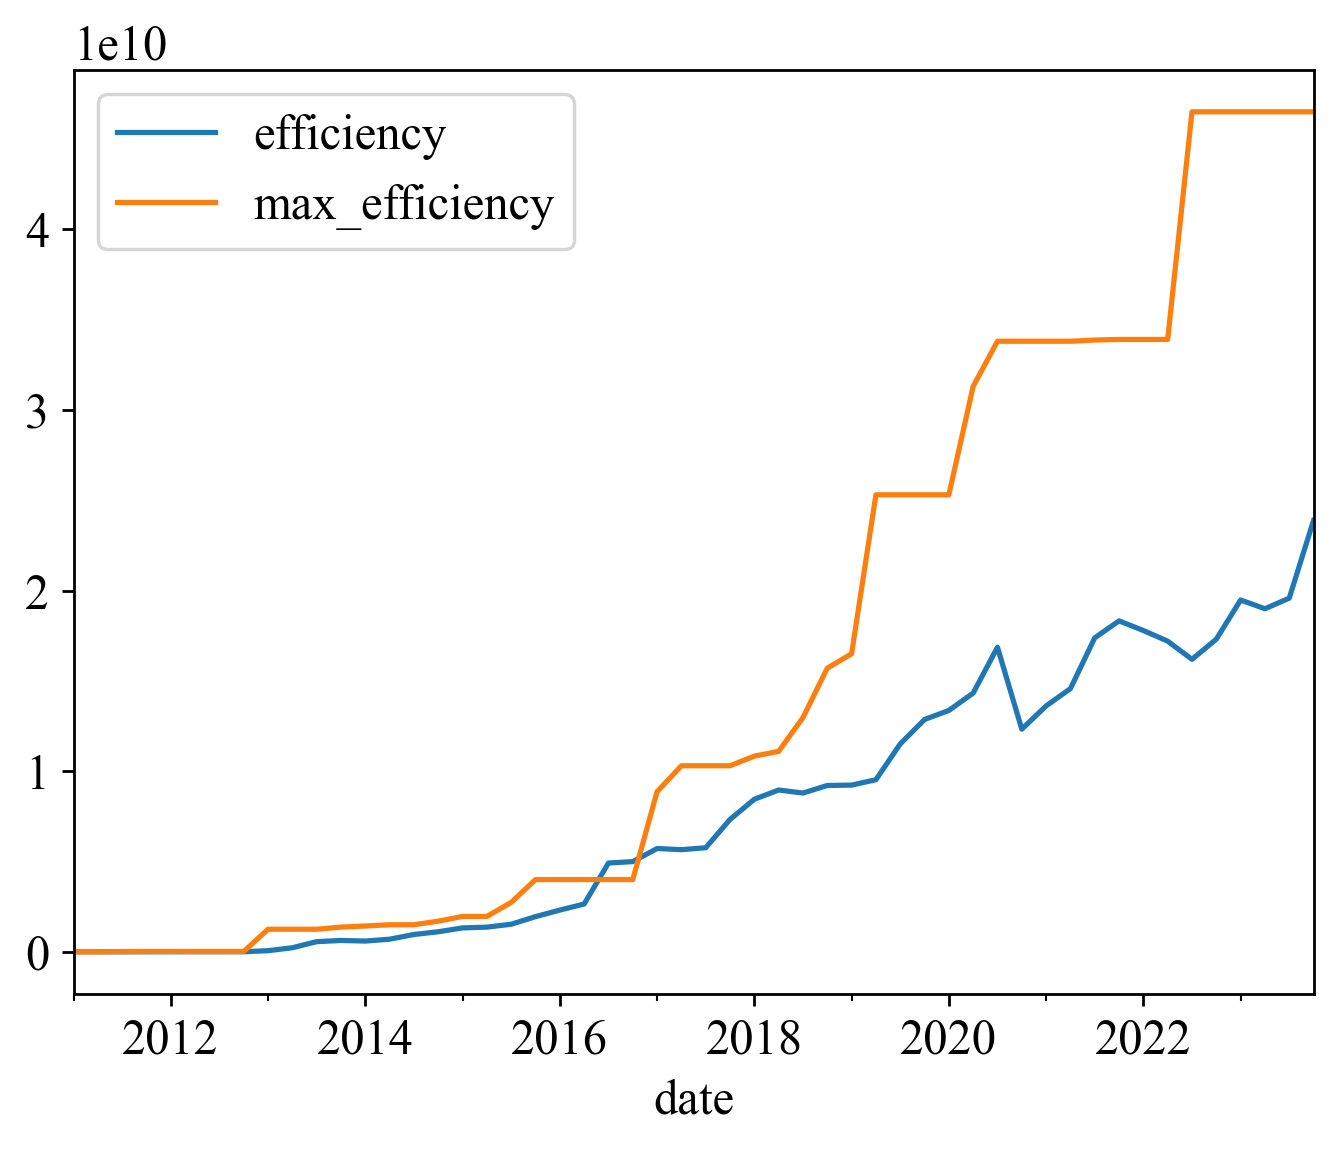

In [48]:
df.plot()

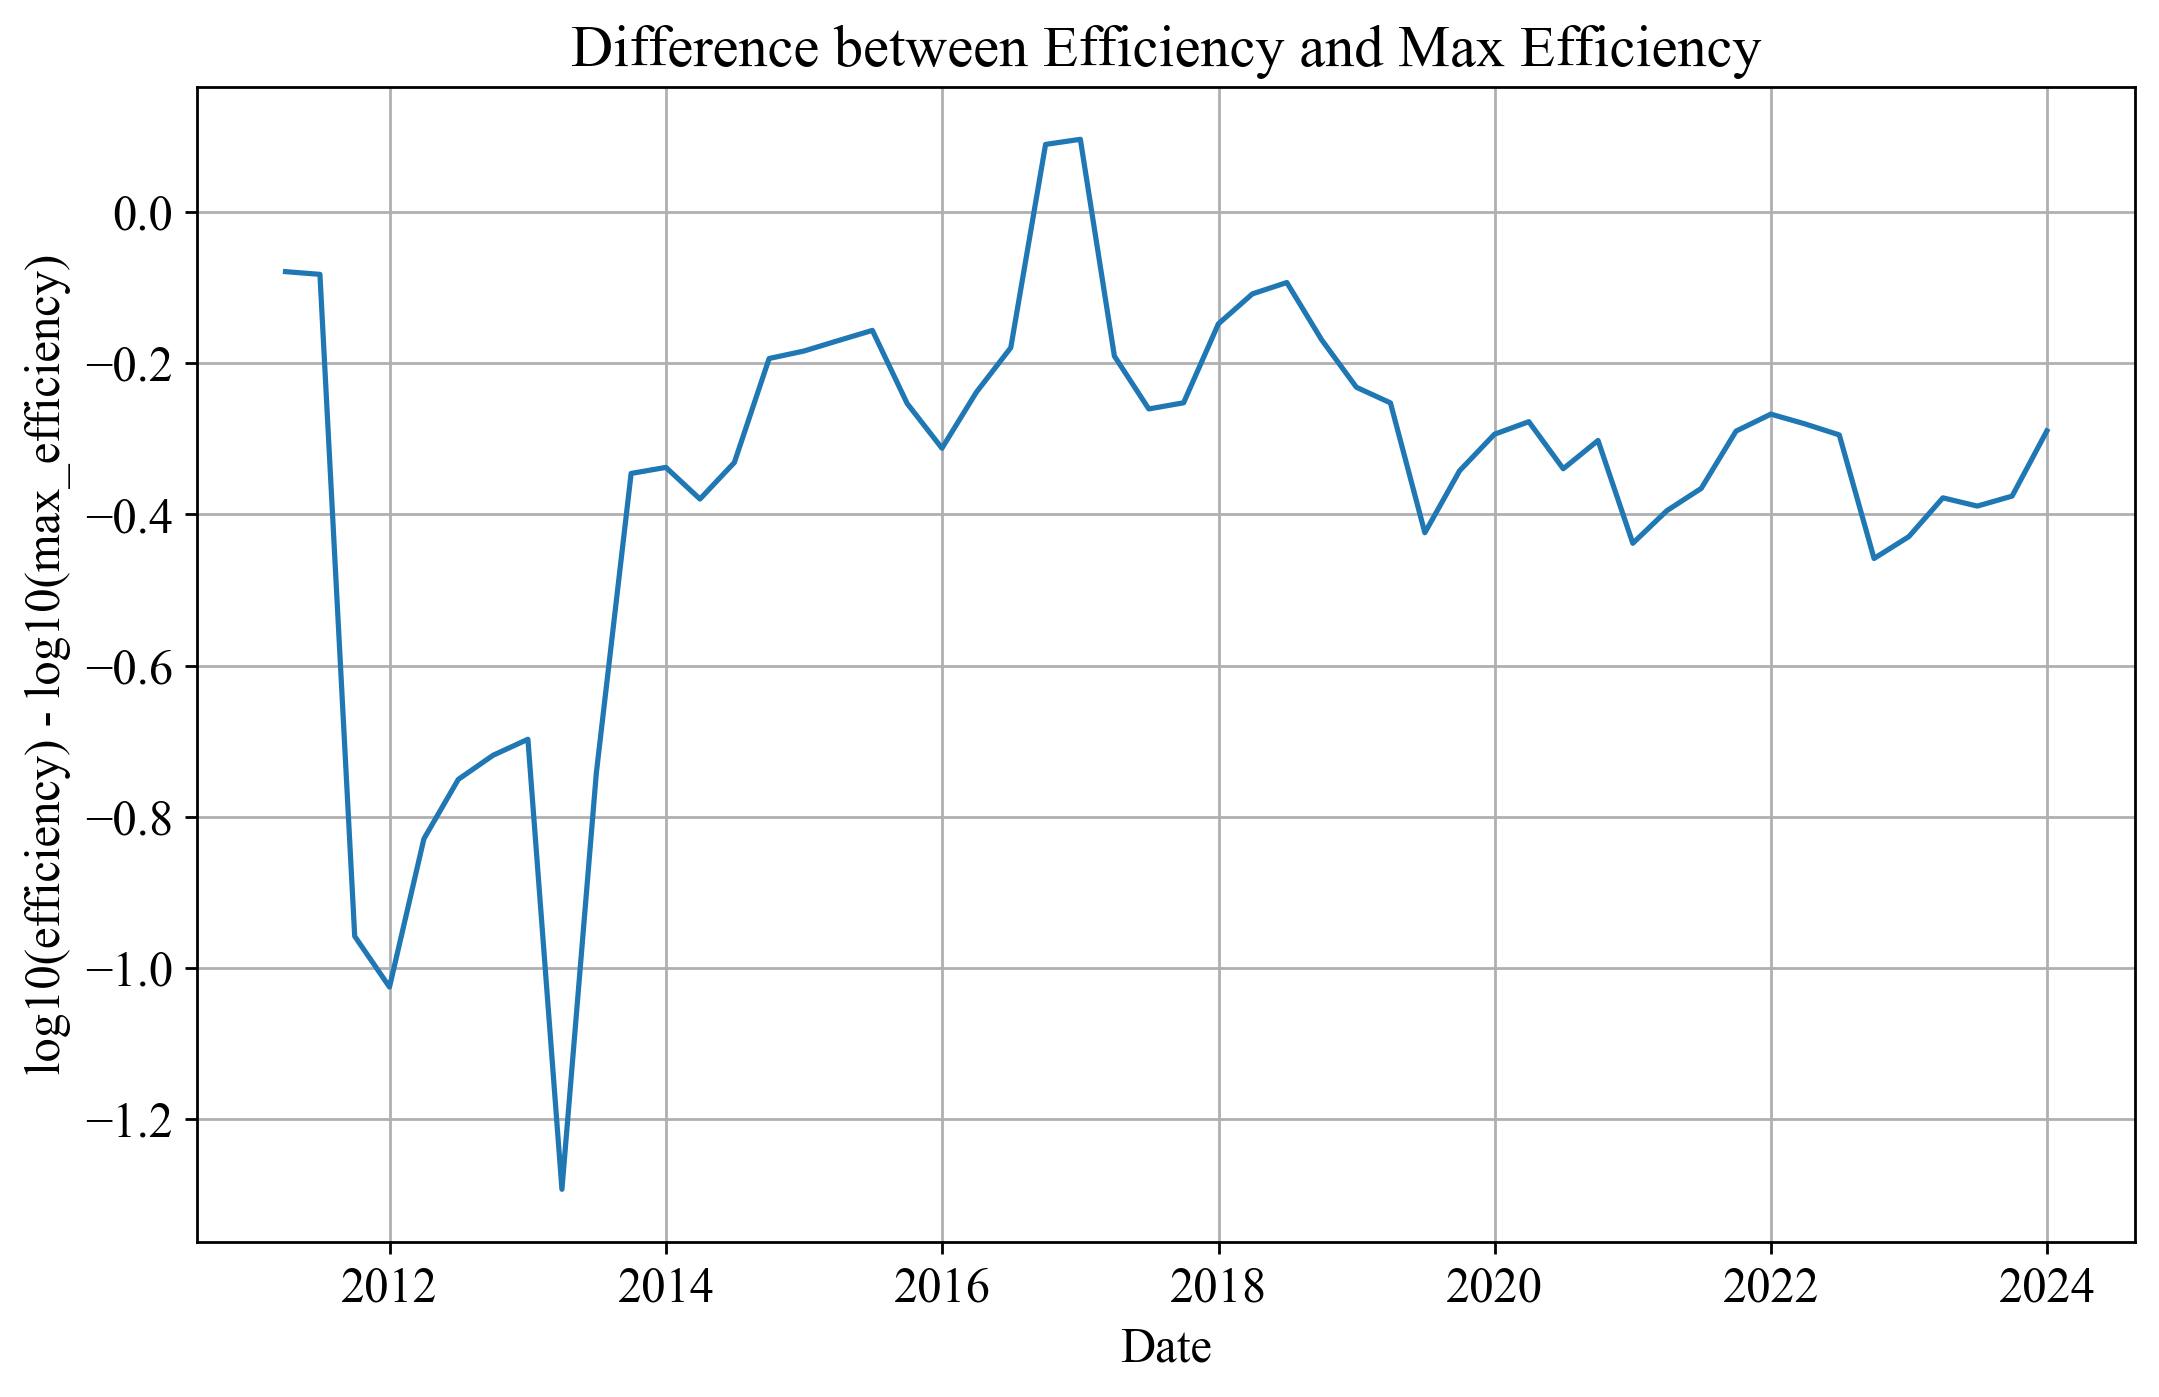

In [49]:
# plot log10(efficiency) - log10(max_efficiency)
plt.figure(figsize=(10, 6))
plt.plot(df.index, np.log10(df['efficiency']) - np.log10(df['max_efficiency']))
plt.xlabel('Date')
plt.ylabel('log10(efficiency) - log10(max_efficiency)')
plt.title('Difference between Efficiency and Max Efficiency')
plt.grid(True)
plt.show()


# part 2

In [50]:
# PART 2
# Plotting the market cap


# this csv only goes back to 2014
# df = pd.read_csv('../pricehistory/price_full.csv')
# btcmarketcap = df[['Start','Market Cap']]
# btcmarketcap.set_index('Start', inplace=True)
# btcmarketcap = btcmarketcap.iloc[::-1]
# btcmarketcap = btcmarketcap[btcmarketcap['Market Cap'] != 0]
# btcmarketcap["day"] = btcmarketcap.index
# btcmarketcap.reset_index(drop=True, inplace=True)
# btcmarketcap

In [51]:
df = pd.read_csv('bitcoin@public.csv',delimiter=';')
btcmarketcap = df[["CapMrktCurUSD","Date"]].dropna()
btcmarketcap.rename(columns={"CapMrktCurUSD":"Market Cap","Date":"day"},inplace=True)
btcmarketcap["day"] = pd.to_datetime(btcmarketcap["day"])
btcmarketcap.index = btcmarketcap["day"]
btcmarketcap = btcmarketcap[["Market Cap"]]

# create a january first for each year and interpolate the market cap
for year in range(2014,2022):
    btcmarketcap.loc[pd.to_datetime(f"{year}-01-01")] = np.nan
btcmarketcap.sort_index(inplace=True)
btcmarketcap.interpolate(inplace=True)

btcmarketcap["day"] = btcmarketcap.index
# looks like
# 4730	6.864460e+11	2021-06-01
# 4731	5.947511e+11	2021-07-15
btcmarketcap

,Market Cap,day
day,,
2010-07-18,2.959592e+05,2010-07-18
2010-07-19,2.792852e+05,2010-07-19
2010-07-20,2.590004e+05,2010-07-20
2010-07-21,2.752665e+05,2010-07-21
2010-07-22,2.037496e+05,2010-07-22
...,...,...
2021-12-16,9.009626e+11,2021-12-16
2021-12-17,8.758845e+11,2021-12-17
2021-12-18,8.867044e+11,2021-12-18


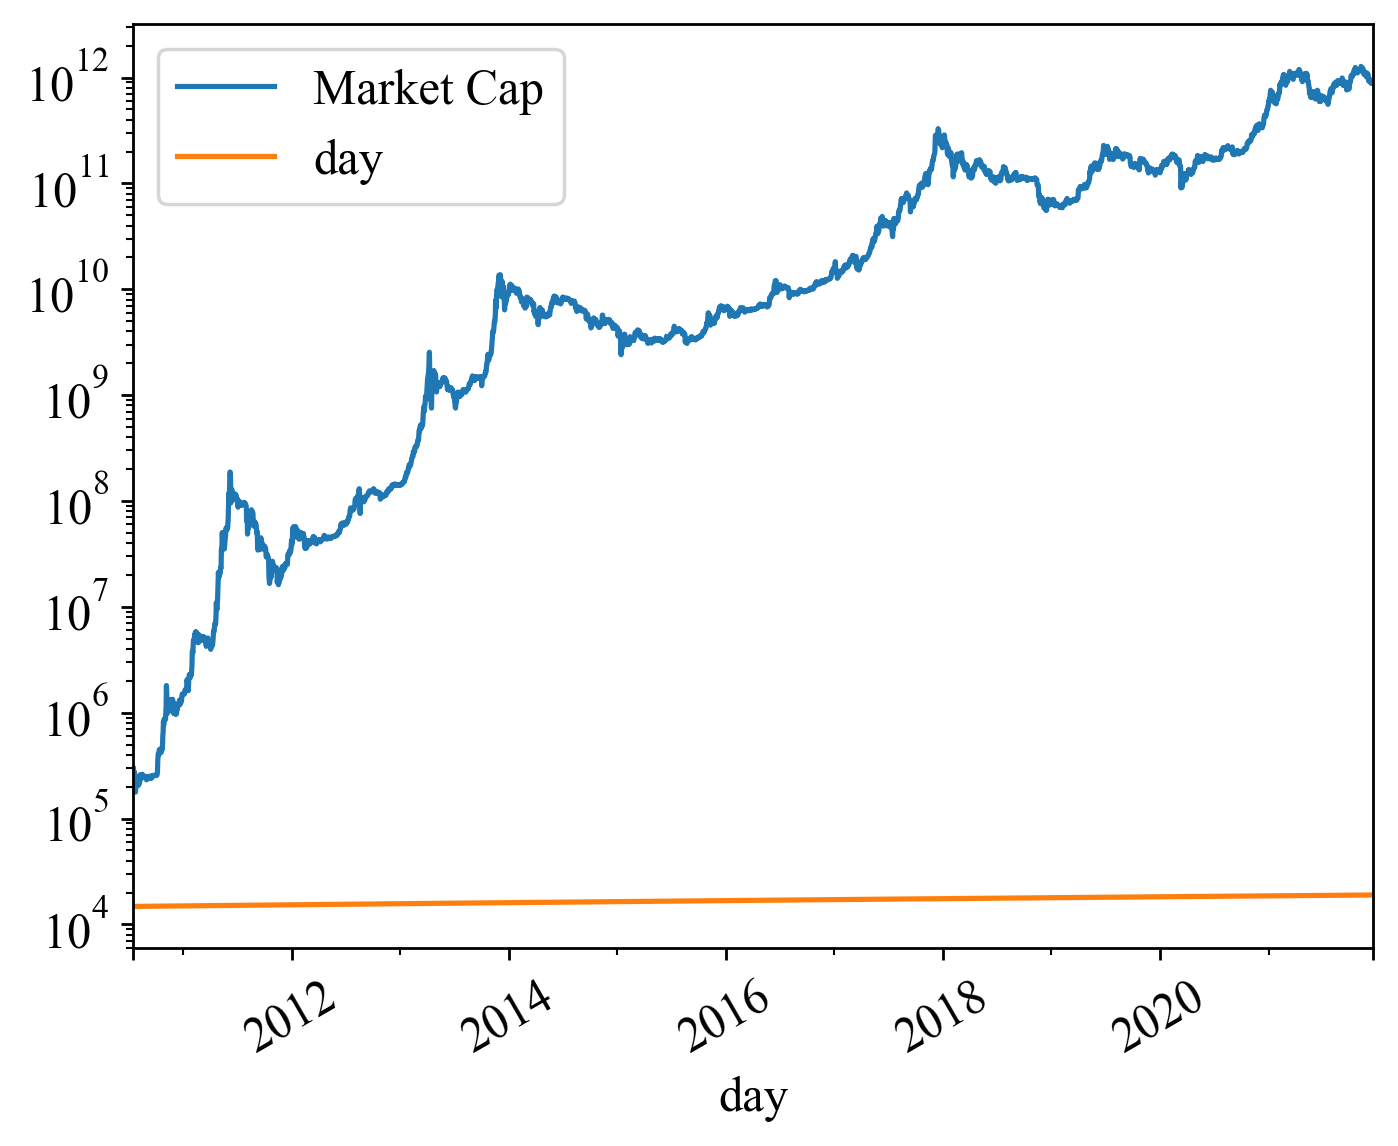

In [52]:
# plot btcmarketcap with log10 y axis, x axis is year and at a 30 degree angle
fig, ax = plt.subplots()
btcmarketcap.plot(ax=ax)
ax.set_yscale('log')
# since the days are not evenly spaced, we can't use np.arange
# plt.xticks([btcmarketcap.index[0],btcmarketcap.index[-1]], [str(btcmarketcap["day"].iloc[0])[:4],str(btcmarketcap["day"].iloc[-1])[:4]])
plt.xticks(rotation=30)
plt.show()

In [53]:
# from https://data.un.org/
gdp = pd.read_csv('gdp.csv', encoding='ISO-8859-1') # Country,Year,TypeOfValue,Value
gdp = gdp[gdp['TypeOfValue'] == 'GDP in current prices (millions of US dollars)']
gdp = gdp[["Country","Year","Value"]]
gdp = gdp.reset_index(drop=True)
# ignore all rows that come before the first row that has "Afghanistan" in the country column
gdp = gdp.iloc[gdp[gdp['Country'] == 'Afghanistan'].index[0]:]
gdp = gdp.reset_index(drop=True)
gdp["Value"] = gdp["Value"].str.replace(",","").astype(float)*1e6
gdp # now looks like: 0	Afghanistan	1995 2.757000e+09

,Country,Year,Value
0,Afghanistan,1995,2.757000e+09
1,Afghanistan,2005,6.221000e+09
2,Afghanistan,2010,1.469900e+10
3,Afghanistan,2015,1.871300e+10
4,Afghanistan,2019,1.890400e+10
...,...,...,...
1480,Zimbabwe,2010,1.204200e+10
1481,Zimbabwe,2015,1.996300e+10
1482,Zimbabwe,2019,2.259500e+10
1483,Zimbabwe,2020,2.166500e+10


c:\ProgramData\Anaconda3\envs\py310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


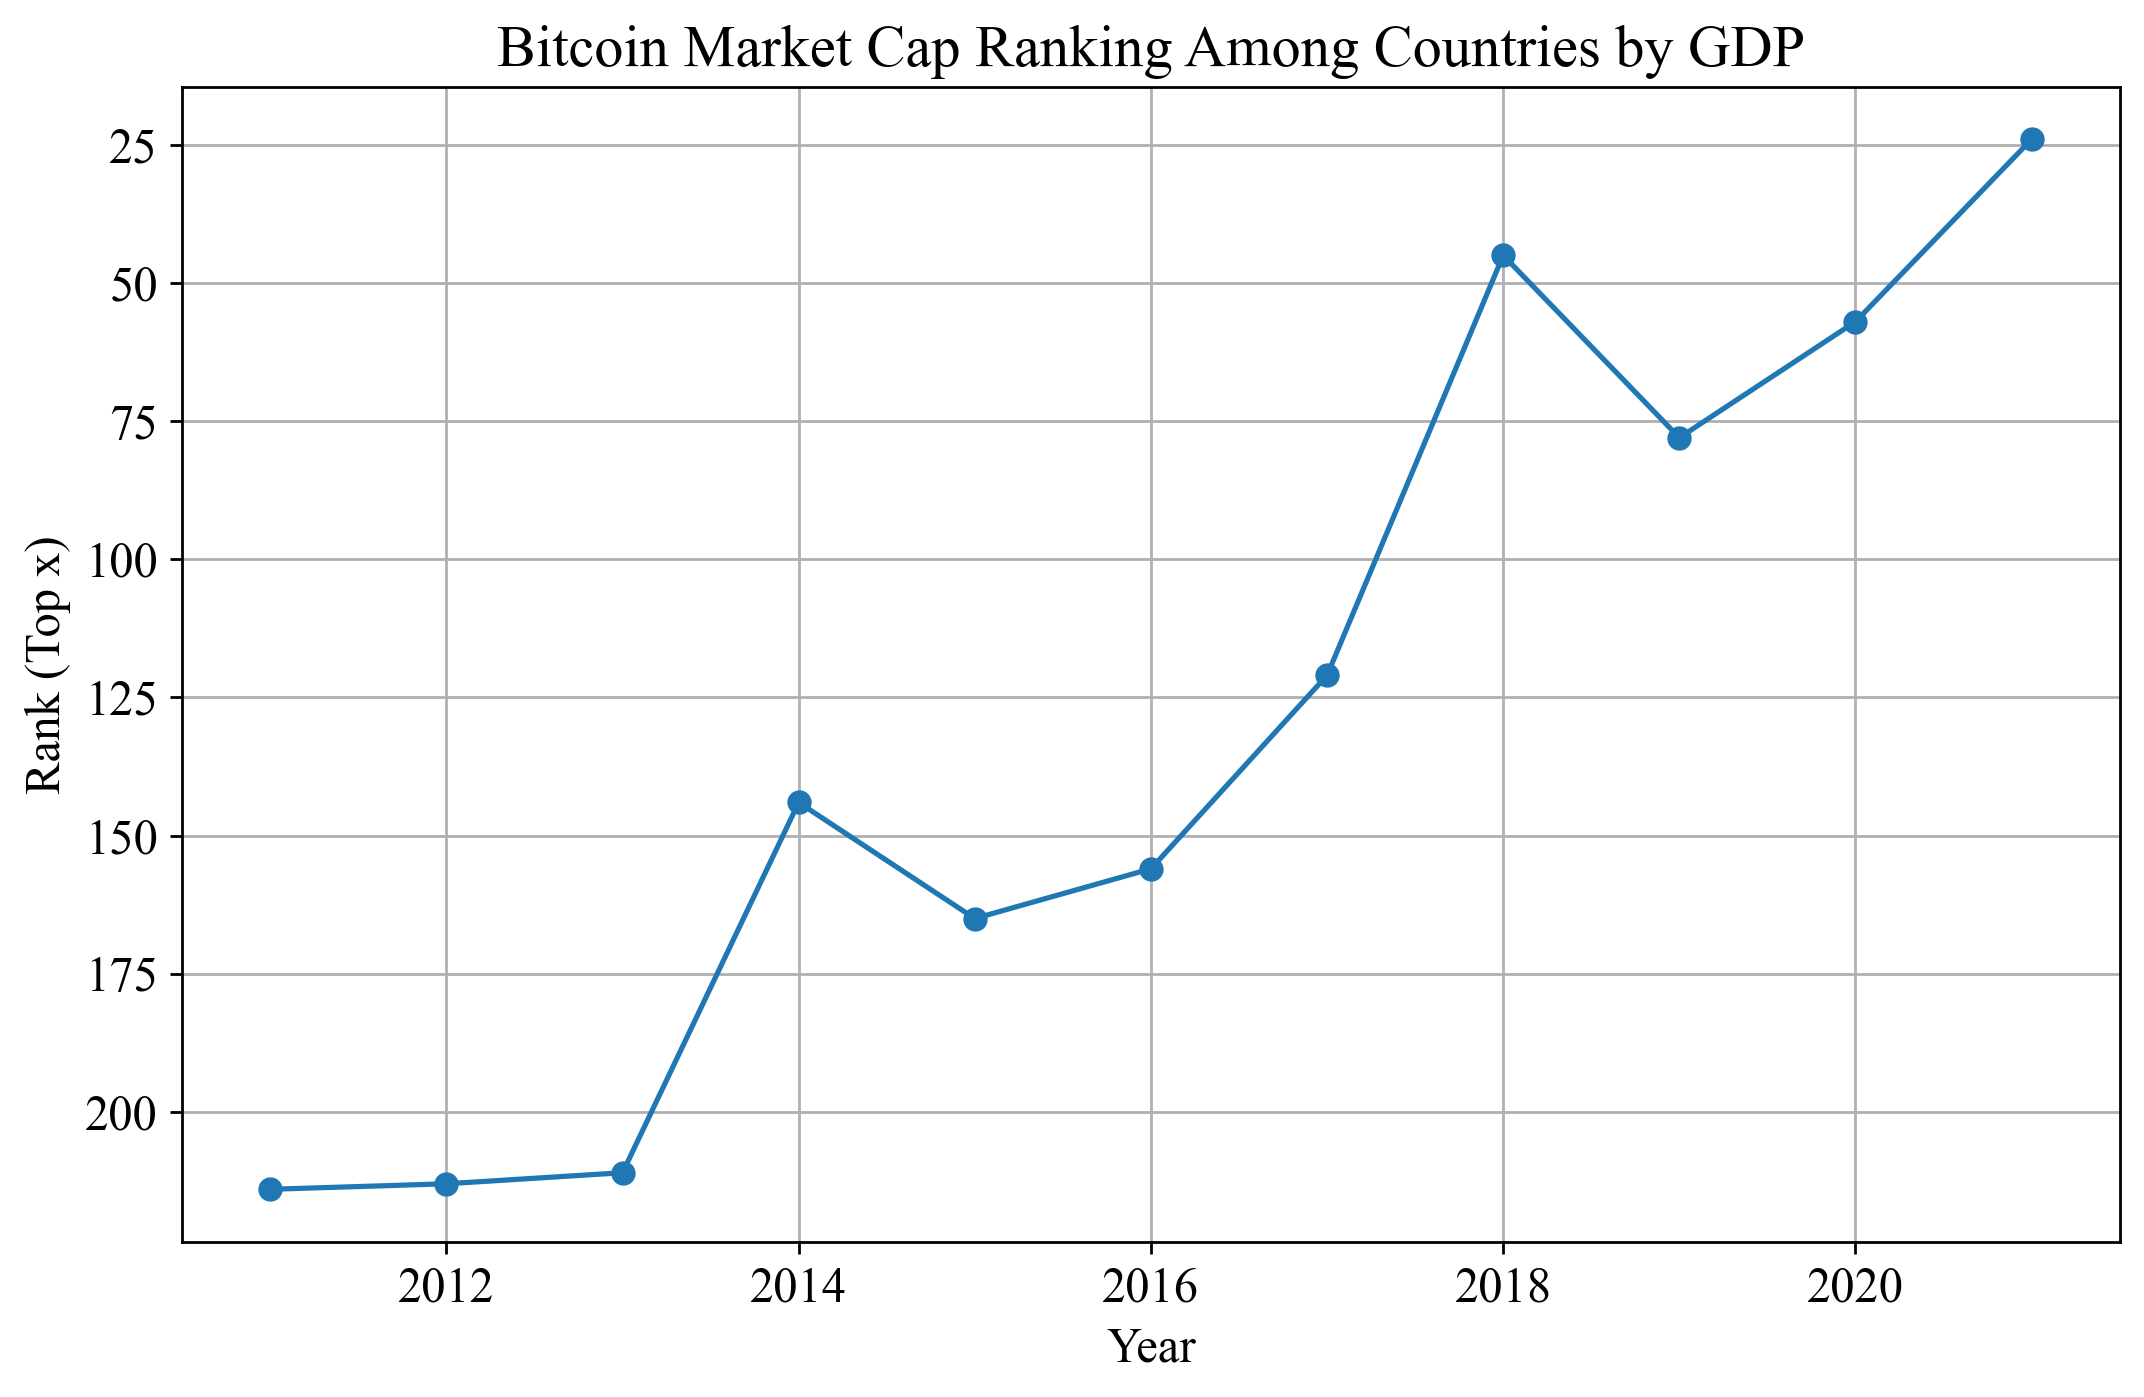

In [54]:
# Step 1: Take the natural logarithm of every value in the 'Value' and 'Market Cap' columns
gdp['ln_Value'] = np.log(gdp['Value'])
btcmarketcap['ln_Market_Cap'] = np.log(btcmarketcap['Market Cap'])

first_year = 2011

# Step 2: Interpolate missing GDP values for each country from first_year to 2021
# First, pivot the gdp dataframe for easier manipulation
gdp_pivot = gdp.pivot(index='Country', columns='Year', values='ln_Value')

# Interpolate linearly across the years for each country
gdp_interpolated = gdp_pivot.reindex(columns=range(1995, 2022)).interpolate(axis=1)

# Filter out the years we are interested in (first_year-2021)
gdp_interpolated = gdp_interpolated.loc[:, first_year:2021]

# Step 3: Extract Bitcoin market cap for each January 1st from first_year to 2021
btcmarketcap['Date'] = pd.to_datetime(btcmarketcap['day'])
btc_jan_1st = btcmarketcap[btcmarketcap['Date'].dt.month == 1]
btc_jan_1st = btc_jan_1st[btc_jan_1st['Date'].dt.day == 1]
btc_jan_1st = btc_jan_1st.set_index(btc_jan_1st['Date'].dt.year)
btc_jan_1st = btc_jan_1st.loc[first_year:2021, 'ln_Market_Cap']

# Step 4: Rank Bitcoin market cap among the countries' GDPs and plot the rankings
rankings = pd.DataFrame(index=range(first_year, 2022))
for year in range(first_year, 2022):
    year_gdp = gdp_interpolated[year].dropna()
    btc_cap = btc_jan_1st.loc[year]
    rank = (year_gdp < btc_cap).sum() + 1  # Ranking position; +1 because rank starts from 1
    rankings.loc[year, 'Rank'] = rank

# Step 5, take the amount of countries and substrack the rankings
countries_count = gdp_interpolated.shape[0]
rankings['Rank'] = countries_count - rankings['Rank'] + 1

# Plotting the rankings
plt.figure(figsize=(10, 6))
plt.plot(rankings.index, rankings['Rank'], marker='o')
plt.title('Bitcoin Market Cap Ranking Among Countries by GDP')
plt.xlabel('Year')
plt.ylabel('Rank (Top x)')
plt.grid(True)
# invert y axis
plt.gca().invert_yaxis()
plt.show()

In [55]:
countries_count

214

In [56]:
np.array(gdp_interpolated.index)

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia (Plurin. State of)',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Chile', 'China', 'China, Hong Kong SAR', 'China, Macao SAR',
       'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica',
       'Croatia', 'Cuba', 'Curaï¿½ao', 'Cyprus', 'Czechia',
       'Cï¿½te dï¿½Ivoire', "Dem. People's Rep. Korea",
       'Dem. Rep. of the Congo', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equ